# PJM Hourly Energy Consumption Forecasting Project

## DS675-854 Machine Learning Final Project

## Team Members
* John Vitz - EDA and XGBoost, Result Analysis <br>
* Matthew Pennington - Prophet and Neural Network Models <br>
* Cheuk Kay Mary Ng - EDA and Result Analysis, Report Compilation <br>

### Project References and Resources

- PJM Hourly Energy Consumption Data: [Kaggle Dataset](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption/data)
- Meteostat Weather Data: [Meteostat](https://meteostat.net/en/)
- Facebook's Prophet Model: [Prophet](https://facebook.github.io/prophet/)
- XGBoost Model: [XGBoost](https://xgboost.readthedocs.io/en/stable/)
- Tensorflow LSTM Model: [LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)

In preparation for this project, a review of other public submissions and literature on Kaggle and academic journals was undertaken to ensure the adoption of best practices and to explore innovative modeling techniques.

---

## Background

The PJM Interconnection operates a competitive wholesale electricity market that helps to ensure the reliability of the largest electric grid in North America, serving parts of the Eastern and Midwestern United States. This project leverages the PJM hourly energy consumption data available on Kaggle, which provides insights into the patterns of electricity usage and pricing across different regions from around 2002 to 2018.

Electricity generation and consumption are fundamentally influenced by a complex network of power plants, which respond dynamically to the demands of the energy market managed by PJM. The cost of electricity fluctuates to encourage the cycling on and off of generation based on demand, which itself is influenced by daily and seasonal patterns, and can be disrupted by abnormal conditions such as extreme weather events.

### Objectives

The primary goal of this project is to develop models capable of forecasting future electricity consumption based on historical data. Accurate forecasts are crucial for:

- Informing trading decisions in the energy market.
- Scheduling of power plant maintenance during periods of low demand
- Enhancing the grid's reliability by anticipating changes in demand.

We focus on training several models that can perform realtime forecasting of data, forecasting MW demand up to 7 days into the future. This reflects the need for utilities to plan ahead for when they intend to bid into the energy market. Given accurate forecast data, a utility can maximize it's expected return on investment by selling power a points of highest expected demand.

### Data Overview

The dataset from Kaggle includes hourly measurements of electricity consumption (in megawatts, MW) and pricing across various PJM regions. This data exhibits cyclical behavior, influenced heavily by temperature variations and seasonal trends, such as increased air conditioning use during hot weather.

In our analysis, we are focused on the aggregate PJM Eastern region, labeled [PJME_hourly.csv](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption/data) in the Kaggle data source. This data only contains two columns, Datetime and PJME_MW, which is a measure of the combined MW consumption by hour for the entire PJM Eastern region.


| Datetime             | PJME_MW |
|----------------------|---------|
| 2002-12-31 01:00:00  | 26498.0 |
| 2002-12-31 02:00:00  | 25147.0 |
| 2002-12-31 03:00:00  | 24574.0 |
| 2002-12-31 04:00:00  | 24393.0 |
| 2002-12-31 05:00:00  | 24860.0 |
| 2002-12-31 06:00:00  | 26222.0 |
| 2002-12-31 07:00:00  | 28702.0 |
| 2002-12-31 08:00:00  | 30698.0 |
| 2002-12-31 09:00:00  | 31800.0 |
| 2002-12-31 10:00:00  | 32359.0 |
| 2002-12-31 11:00:00  | 32371.0 |
_Sample of PJME_MW data_

This subset of the data was selected since it is the largest sample to pull from.

# PJM Territory Map
## PJM East is composed of several territories, including NJ, Delaware, Maryland, DC, Virginia and Pennsylvania

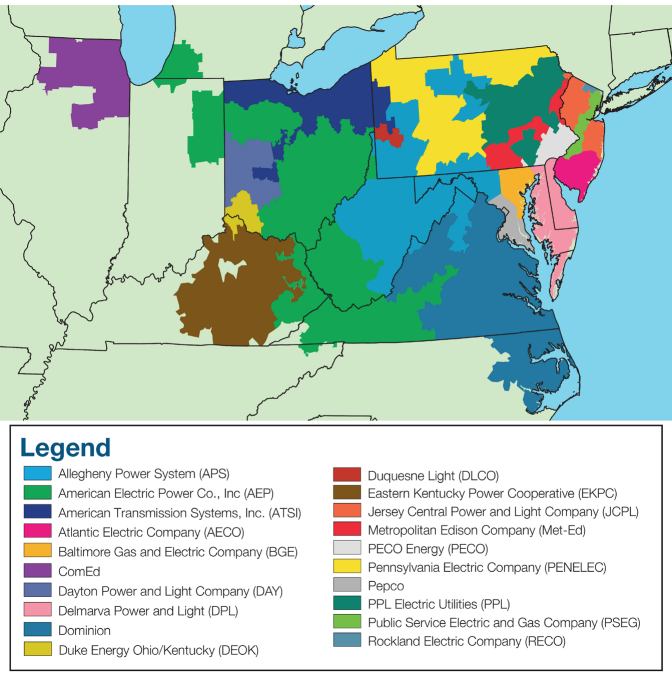

#### Meteostat Weather Data

As an experiment, we also imported in historical temperature data into our model. This data is imported for each hour in a sample region (in this analysis, we utilize Atlantic City).

Data is retrieved using the Meteostat API.

### Approach

Our intention is
This project will utilize time series analysis techniques to model electricity consumption. Our data is split training and test segments, and where feasible, also split into validation segments.

This approach allows for the evaluation of the model's performance over a typical forecasting horizon used in trading scenarios, specifically targeting a 7-day forecast period.

This report will proceed to detail the data preprocessing steps, feature engineering, model selection, and the results of the forecasting models.

---

## What Differentiates Our Work

Our approach is unique in several ways:
1. We forecast out over a large window of time
  * Many other approaches focus entirely on forecasting out 1 hour into the future
  * This is more challenging since it requires shaping our input and output data carefully for each model
  * It also takes substantially more computational power to train a model forecasting on so much data
2. We compare multiple techniques, including models built using Prophet, LSTMs and XGBoost
  * This required attention on the training and testing process to ensure models were comparable
3. Experimentation with temperature data
  * Air temperature data is imported in externally and added as a feature to our dataset
  * This is intended to see if historical air temp trends provide any information useful to forecasting demand

## EDA and Predictions

The PJME dataset has 145,362 unique rows. There are two columns - PJME_MW (float64 representing Megawatts), and Datetime (hourly datetime object). The data is from 2002-01-01 01:00:00 hourly until 2018-08-03 00:00:00.

| PJME_MW | Datetime |
| ------|-----|
| float64  | datetime  |

Data preparation involved cleaning the PJME dataset by making sure all datetime values were datetime objects, removing duplicates, and interpolating missing values. This pre-processing step is essential for ensuring the model is being trained and tested on a continuous time series.

An analysis of the PJME dataset showed a mean that was greater than the median, suggesting right-skewed data. Outliers were largely above the mean rather than below. Graphs on energy use and a right-skewed histogram confirm extreme, seemingly cyclical spikes in consumption.


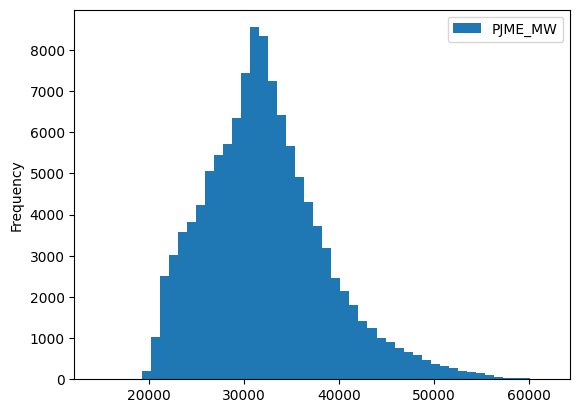

To investigate what causes these spikes, a more in-depth analysis was conducted on the dataset after decomposing the datetime column into hour, day, day of week, day of year, week (of year), month (of year), year, and quarter -- all integer values. Intuitively, these individual columns matter given noticeable patterns in plotted energy use over time.


Trend and seasonal affects were checked for using an ADF unit root test and KPSS test on the time series data. Both reported that the data is stationary, so modeling behavior over time should give consistent results.


Boxplots on MW consumption by each of the created time features show obvious trends by month, week, day of the week, and hour of the day. Seasonality is obvious in boxplot MW by month of year, with peaks energy use in the summer months of June, July, and August. There is a similar pattern in the boxplot for MW by week of year. The boxplot for MW by hour of day also has a pattern that dips in the very early morning hours and peaks in the early evening, which makes sense given the usual working household's habits.

<b>Given the above analysis, we predicted that month, weekday, and hour will have the strongest effect in models.</b>
<br>Given the strong seasonality implied by this, we also expect the incorporation of temperature data to result in more effective models.


The temperature data was requested from the National Oceanic and Atmospheric Administration (NOAA) and the data extracted into two columns: datetime (hourly datetime object, same as the PJME dataset), and temperature in Fahrenheit. This data was also prepared in a similar manner to the PJME one. The power and temperature data was also standardized before combination.

Plotting MW with air temperature produced an expected "duck" curve, which shows peaks at the start and end of the day with a deep valley in between.

## Design Choices

We retrofitted the XGBoost model to work with timeseries data and output predictions for multiple data points simultaneously. We flattened the output arrays into one dimension to fit with sklearn's XGBoost model.

The usual 80%/20% split of train/test data was used for each model.

With exception to the Prophet model, each model was fed 14 days of historical data, with a target of predicting the next 7 days of load.

We trained the models on the first 80% of our data (roughly 2002 to 2015). Training our models through validation testing was performed on this file, leading us to discover the specific hyperparameters used in our project.

Our primary goal was to explore the performance differences in various different models.

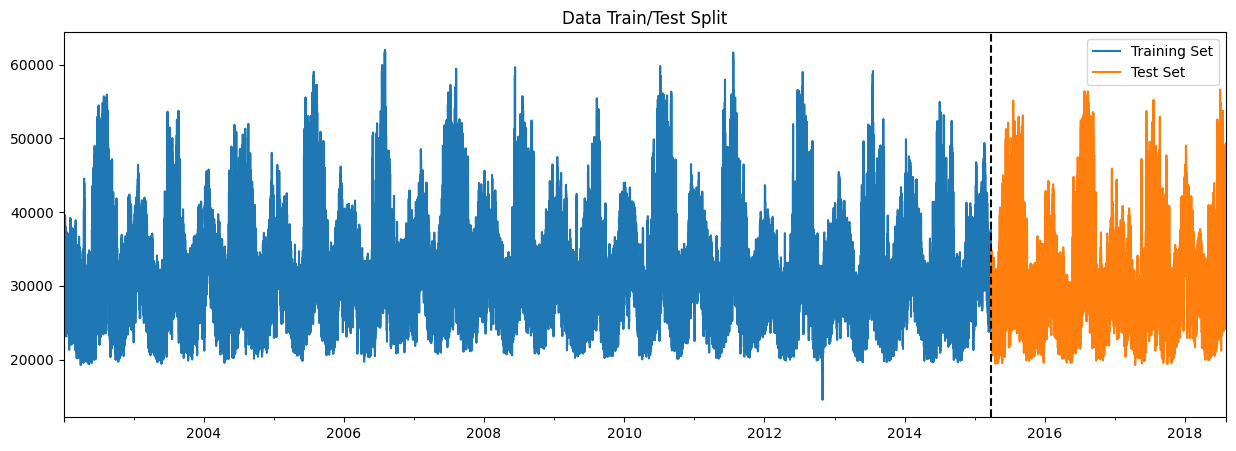


## Results and Insights

Our evaluation metric is the root mean square error (RMSE) and the mean correlation score R². This is computed as the average across all predictions over the test data. This includes predictions starting from 1 hour going up to 7 days into the future.

We also report on runtime we experienced training these models, which was done using Google Colab L4 GPU.

Overall results are summarized below:

| Model             | R² Score | RMSE    | Wall Time | CPU Time |
| ------            |-----     |-------- |--------|--------|
1. Prophet          | 0.5937   | 4135.36 | 1m 46s | 10.6s
2. LSTM             | 0.6593   | 3782.63 | 12m 36s | 14m 32s
3. LSTM + temp data | 0.6631   | 3761.12 | 12m 42s | 14m 40s
4. XGBoost          | 0.6912   | 3601.90 | 6m 6s | 1h 35m

The best results on test data came from the XGBoost model with a mean R² of 0.68. It also trained more quickly than the neural networks, making it the best overall performer. The LSTM neural network with just PJME data had a mean R² of 0.59 and was slow to train. The temperature-supplemented LSTM neural network had a mean R² of __ and performed very closely to the pure LSTM. Both neural networks trained for 20 epochs. The Prophet model performed the worst at R² = 0.59, though it was easiest to implement.

The decay of R² scores by hour had a similar trend across the models. R² scores start at 0.8 and above and deterioriate, with notable dips in score around the 24 hour mark. Interestingly, the R² score for the pure LSTM model goes up and down a few times after 50 hours. XGBoost had the smoothest curve in contrast to this.

### Model #1 - Prophet

#### Introduction
We selected Facebook's open-source forecasting tool, [Prophet](https://facebook.github.io/prophet/), to establish a baseline for our analysis. Prophet is well-regarded for its ease of use and efficiency in handling time-series data, making it an ideal choice for initial comparisons with more complex machine learning models. Its implementation in Python is straightforward and computationally efficient, typically requiring less than two minutes to train on our dataset.

#### Model Implementation
Prophet operates by decomposing time series data into components that represent the underlying trend and seasonality. This decomposition allows the model to handle a wide range of time series patterns with robust performance across different scenarios.

- **Data Input**: Our dataset spans from 2002 to 2018, with the initial period from 2002 to 2015 used for training the model. The subsequent years from 2015 to 2018 serve as our testing period, where we evaluate the model's forecasting capabilities.
- **Training Details**: The model is trained on the entire dataset from 2002 to 2015 without additional feature engineering, relying solely on the datetime and power consumption (MW) values.

#### Forecasting and Performance
In testing, Prophet generated forecasts that matched the general patterns observed in the actual data:
- **Forecast Characteristics**: The model produced forecasts that essentially repeat on a yearly cycle. While this approach captures the long-term trends and seasonal patterns effectively, it struggles to model shorter-term fluctuations, which are critical in high-resolution forecasting tasks.
- **Evaluation Metrics**: The performance of Prophet on our test set resulted in an R² of 0.5937. This score, while modest, reflects the model's capability to capture the macro trends but highlights its limitations in adapting to more dynamic changes within the dataset.

#### Limitations and Future Work
The primary limitation observed with Prophet in our context is its inability to effectively capture short-term variations, which are often driven by more complex dynamics than those captured by seasonal and trend components alone.

- **Future Enhancements**: To improve forecasting accuracy, future iterations could incorporate additional regressors into Prophet, such as weather conditions or economic indicators, which might explain some of the short-term variations in energy consumption.
- **Comparative Analysis**: Continuing to use Prophet as a baseline is valuable for benchmarking more complex models, ensuring that any additional complexity provides a commensurate improvement in performance.

#### Conclusion
Prophet serves as a robust baseline model, offering quick training times and decent predictive performance with minimal tuning required. It provides a solid foundation for comparing more sophisticated machine learning approaches, guiding further enhancements in our predictive modeling efforts.

# Model #2 - LSTM (time only)
* Plots the average MSE and R^2 for model predictions forecasted over 7 day period.

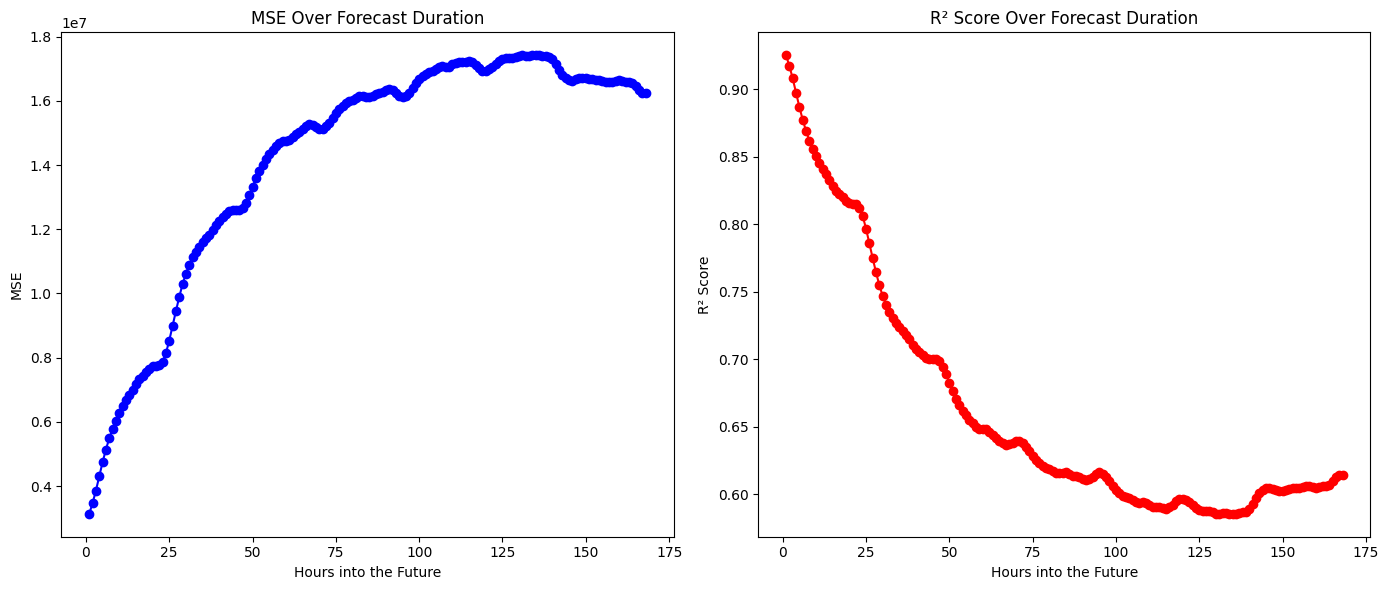

### Model #3 - LSTM (Time + Temperature)

#### Overview
Our third model extends the LSTM architecture used in Model #2 by integrating ambient air temperature data alongside electricity consumption metrics. This model employs a two-layer LSTM structure identical to Model #2 but is adapted to handle multivariate input.

#### Data Integration and Preparation
- **Temperature Data**: Historical hourly temperature data for Atlantic City, NJ, within the PJM Eastern territory, was sourced from [Meteostat](https://meteostat.net/). This selection is based on the premise that regional weather conditions significantly affect energy consumption.
- **Data Synchronization**: Temperature data was synchronized with MW consumption data to create input vectors for the LSTM, each containing two features per timestamp—electricity consumption and corresponding temperature for the previous 14 days.

#### Model Architecture
- **Input Features**: Each input vector consists of data spanning the last 14 days, targeting to predict MW consumption for the subsequent 7 days.
- **Layers Configuration**: The LSTM features a first layer with 50 neurons and a second layer with 16 neurons, using a `tanh` activation function. A 20% dropout rate is applied between layers to mitigate overfitting.

#### Hypothesis Testing and Results
- **Initial Hypothesis**: We posited that including temperature data would enhance the model's predictive accuracy by correlating temperature fluctuations with changes in energy consumption, particularly during periods of extreme temperatures.
- **Analysis and Findings**: Visual analysis of temperature against MW consumption suggested a strong correlation. However, when incorporated into the LSTM model, the temperature data did not significantly improve the predictive performance compared to Model #2, which did not include temperature data. This outcome suggests that while there is a correlation, the temperature data as used did not add predictive value beyond what the LSTM could capture from the MW data alone.

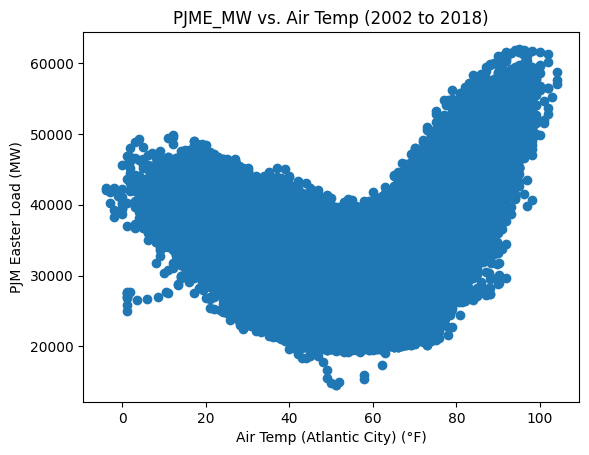

### Model #4 - XGBoost

#### Overview
Our fourth model utilizes XGBoost, a powerful and widely used machine learning algorithm known for its speed and performance, particularly in competitive machine learning competitions. XGBoost excels in regression tasks due to its robust handling of various types of features and its ability to model complex nonlinear relationships.

#### Data Preparation and Feature Engineering
- **Feature and Target Construction**: The model uses the past 14 days of hourly electricity consumption data to predict the next 7 days. This involves input vectors of 336 hours and output vectors of 168 hours.
- **Data Transformation**: Like before, we applied a MinMax scaler to the electricity consumption data to normalize the range and enhance model convergence.

#### Model Training and Configuration
- **Model Architecture**: We configured the XGBoost model with 100 estimators and a maximum depth of 3. This setup was chosen to balance between model complexity and training efficiency. Given the runtime, it was not feasible to test other configurations.
- **Training Process**: The model was trained on 80% of the data, with the remaining 20% used for testing. The focus during training was on minimizing the root mean squared error (RMSE), which is a common measure for regression tasks.

#### Performance Evaluation
- **Execution Time**: The model required approximately 1 hour and 35 minutes to train (CPU time), reflecting the substantial computational demand due to the high granularity and volume of data.
- **Model Accuracy**: With an R² of 0.6912 on the test dataset, the model demonstrated a strong ability to capture and predict patterns in electricity consumption.

#### Grid Search
- Grid search was implemented on another variant of the selected model, using a search space of 50 or 200 estimators, and a max depth of 3 or 7
- The optimal model selected had max_depth of 3 and 200 estimators
- Data was split into 70% training data, 20% validation data, and 10% testing data
- The grid search took several hours to execute
- Interestingly, the "best model" discovered had worse performance statistics than our initial XGBoost model (100 estimators and max depth of 3) with only an R^2 value of 0.61 vs. base model R^2 of 0.69
- Code is listed at end of report for demonstration purposes (note long execution time expected)

#### Conclusion
The XGBoost model was both the best performance wise, but also the most expensive to train. XGBoost is not often used for outputing forecast data like this, so it was interesting to see how it performed. While decent, the training time is too expensive to consider using this model in the future. Also found grid search over this large data set was impractically long.

# Model #4 - XGBoost
* Plots the average MSE and R^2 for model predictions forecasted over 7 day period.
* Preformance is the best amongst the models we tested

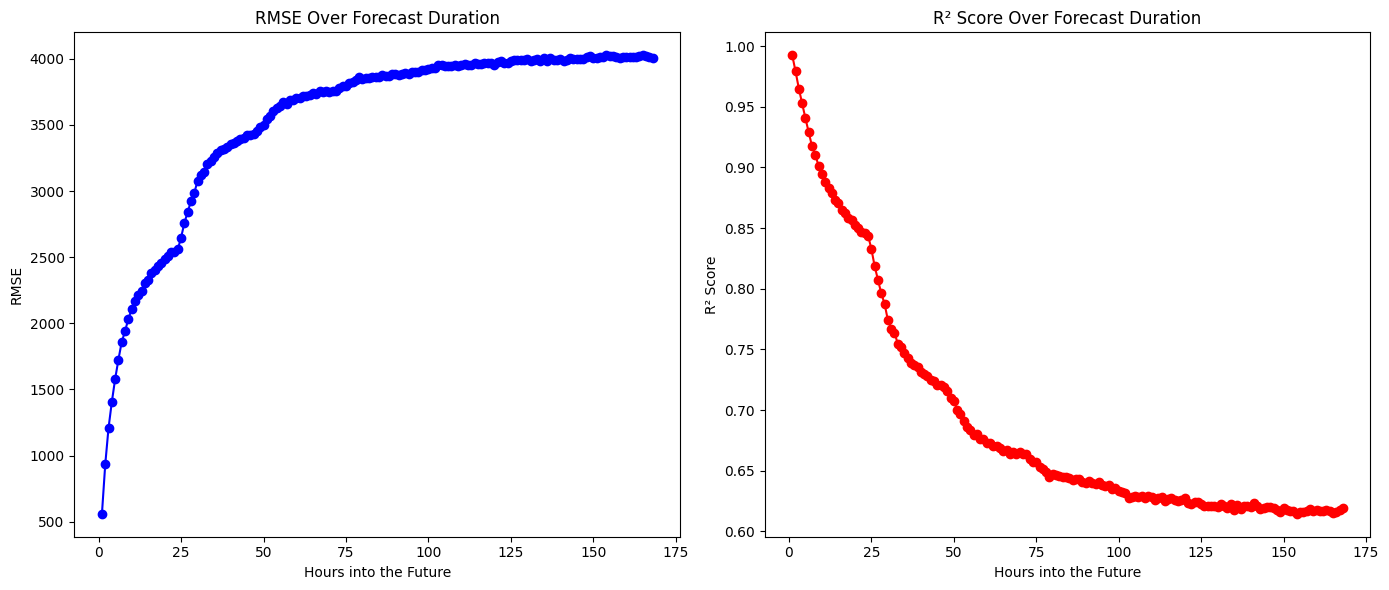

## Conclusions and Future Opportunities

### Summary of Achievements
This project successfully developed and compared several predictive models using the PJM Hourly Energy Consumption data. Key achievements include:
- **Effective Model Development**: Models ranging from traditional time series (Prophet) to advanced machine learning techniques (LSTM and XGBoost) were implemented and assessed.
- **Incorporation of External Data**: Temperature data from Meteostat was integrated to explore its impact on forecasting accuracy.


### Key Findings
- **XGBoost's Superior Performance**: The XGBoost model outperformed others in terms of accuracy with an R² of 0.6912, although it required the longest training time.
- **Grid Search Issues**: Our implementation of grid search using k-fold validation took a significant amount of time, and did not discover improved model performance - this suggests some caution should be taken when implementing grid search on large datasets
- **Limited Impact of Temperature Data**: Including temperature data did not significantly enhance the LSTM model’s performance, indicating that the electricity consumption data alone provided sufficient predictive power for the model frameworks used.
- **Scalability and Efficiency Concerns**: The extensive computational resources required by models, especially XGBoost, highlighted potential scalability and efficiency challenges for operational use.

### Future Directions
- **Advanced Feature Engineering**: Exploring more sophisticated feature engineering techniques and incorporating additional predictors like weather forecasts could further improve model accuracy.
- **Model Optimization**: Systematic hyperparameter tuning and exploration of different model architectures could yield better performance and efficiency.
- **Cross-Validation Implementation**: Employing cross-validation techniques to assess model robustness and avoid overfitting, especially for models with significant training times like XGBoost.

### Final Thoughts
Model development is hard! This project has made it clear that having a good foundation in machine/deep learning is essential. It's not possible to search the entire hyperspace of potential models, so you need to know where to start and how to make the appropriate manual corrections. Our team appreciates the opporutnity to present this project, and get our hands in real world data.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [ ]:
# PJM East Region: 2001-2018 (PJME)
# estimated energy consumption in Megawatts (MW)
# https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption?select=PJME_hourly.csv
pjme_data = pd.read_csv("PJME_hourly.csv")
pjme_data_original = pjme_data.copy()

# First Glance

Going to take a look over the data, check for duplicate values.

In [ ]:
pjme_data.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [ ]:
pjme_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


In [ ]:
pjme_data.isnull().sum()

Datetime    0
PJME_MW     0
dtype: int64

In [ ]:
type(pjme_data['Datetime'][0])

str

In [ ]:
pjme_data['Datetime'] = pd.to_datetime(pjme_data['Datetime'])

In [ ]:
pjme_data

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0
...,...,...
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0


In [ ]:
len(pjme_data) == len(pjme_data['Datetime'].unique())

False

In [ ]:
len(pjme_data)

145366

In [ ]:
len(pjme_data['Datetime'].unique())

145362

In [ ]:
pjme_data[pjme_data['Datetime'].duplicated() == True]

,Datetime,PJME_MW
106585,2014-11-02 02:00:00,23755.0
115369,2015-11-01 02:00:00,21171.0
124009,2016-11-06 02:00:00,21692.0
132817,2017-11-05 02:00:00,20666.0


This means that there may be duplicate datapoints in our data, 4 to be exact. I investigated each one by examining 2 rows before and after the index position of both duplicates, to make sure none of the duplicates were actually missing next/previous hour values. I will now drop the duplicates and linearly interpolate missing MW consumption datetime values.

In [ ]:
import pandas as pd

def clean_time_series_data(df):
    """
    Cleans the provided DataFrame by setting the datetime column as index,
    removing duplicates, and interpolating missing data.

    Parameters:
    - df: pandas.DataFrame, the DataFrame to clean.

    Returns:
    - pandas.DataFrame, cleaned time series data.
    """
    # Convert datetime column to datetime type if not already
    df["Datetime"] = pd.to_datetime(df["Datetime"])

    # Set the datetime column as the index
    df.set_index("Datetime", inplace=True)

    # Remove duplicates
    df = df[~df.index.duplicated(keep='first')]

    # Generate a complete datetime range
    full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')

    # Reindex the DataFrame to include all hourly intervals
    df = df.reindex(full_range)

    # Interpolate missing values linearly
    df.interpolate(method='linear', inplace=True)

    # sort values based on Year -> Month -> Day
    df = df.sort_index(axis=0)

    return df

In [ ]:
pjme_data = clean_time_series_data(pjme_data)
pjme_data

,PJME_MW
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0
...,...
2018-08-02 20:00:00,44057.0
2018-08-02 21:00:00,43256.0
2018-08-02 22:00:00,41552.0
2018-08-02 23:00:00,38500.0


#### Train / Validation / Test Split

Before going any further, I have to obtain a Train/Validation/Test split in order to avoid data leakage. We have to do a Train/Test split so that we don't use any information about the test set (which is future data that we would not have access to in a real forecasting scenario) in our analysis or model building. If I was to include the test set from here on out, I would be using information about the future on a model built to predict future values, which is impossible in practice.

Time series data is unique in the sense that the train/test split should be based on the past versus most recent X amount of time, rather than a random sample. So we will start from there.

I will do about an 80% / 20% split of train / test data.

Train data will be comprised of data until and including '2015-03-29 06:00:00'.
Test data will be comprised of data after ''2015-03-29 06:00:00'.

Furthermore, Train/Validation splits will be done before modeling, and will somewhat resemble the train / test split.

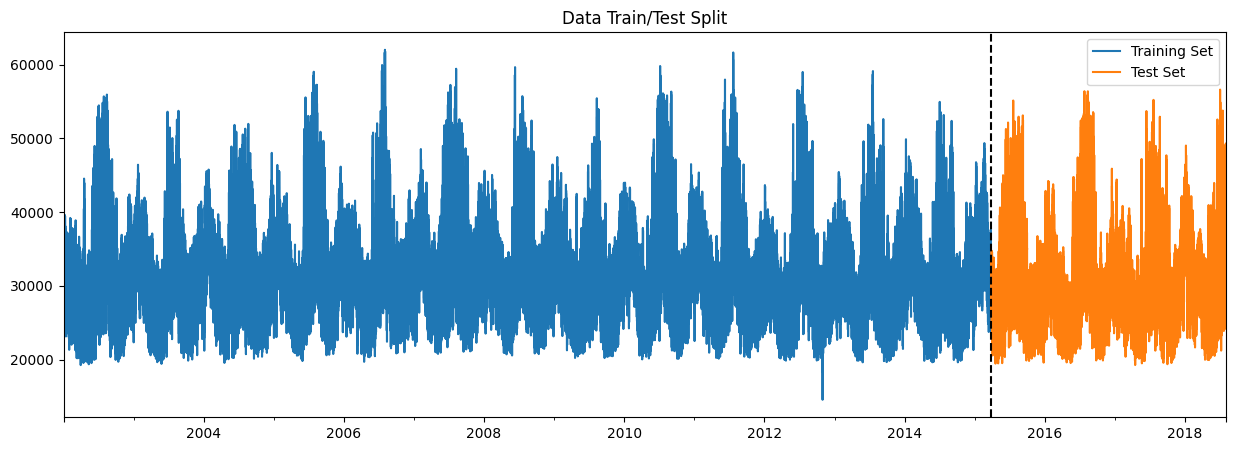

In [ ]:
train_df = pjme_data.loc[:'2015-03-29 06:00:00']
test_df = pjme_data.loc['2015-03-29 07:00:00':]

fig, ax = plt.subplots(figsize=(15, 5))

train_df.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test_df.plot(ax=ax, label='Test Set')

ax.axvline('2015-03-29 07:00:00', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

From here on out, we will only be using the train set in order to do exploration, analysis, and modeling.

### Basic statistics

In [ ]:
train_df.describe()

,PJME_MW
count,116046.000000
mean,32336.373959
std,6436.510073
min,14544.000000
25%,27854.000000
50%,31744.000000
75%,35869.000000
max,62009.000000


The mean is greater than the median, which suggests that the data could be right skewed.

#### What data is more than 2 standard deviations from the mean? What portion is above, and what portion is below?

In [ ]:
std2_upper = train_df['PJME_MW'].mean() + train_df['PJME_MW'].std() * 2
std2_lower = train_df['PJME_MW'].mean() - train_df['PJME_MW'].std() * 2

print(std2_lower)
train_df[train_df['PJME_MW'] < std2_lower].shape[0]

19463.35381266242


23

In [ ]:
train_df[train_df['PJME_MW'] < std2_lower].shape[0] / train_df.shape[0]

0.0001981972666011754

Very few values are more than two standard deviations below the mean.

In [ ]:
print(std2_upper)
train_df[train_df['PJME_MW'] > std2_upper].shape[0]

45209.394106266285


4902

In [ ]:
train_df[train_df['PJME_MW'] > std2_upper].shape[0] / train_df.shape[0]

0.042241869603433124

4.2% of our train data is more than two standard deviations above the mean.

#### Identifying 'outliers' with 1.5 * IQR rule

In [ ]:
IQR = 35869.000000 - 27854.000000
IQR_1_5 = IQR * 1.5
IQR_1_5_low = 27854.000000 - IQR_1_5
IQR_1_5_high = 35869.000000 + IQR_1_5

print(IQR_1_5_low)
train_df[train_df['PJME_MW'] < IQR_1_5_low]

15831.5


,PJME_MW
2012-10-30 01:00:00,15390.0
2012-10-30 02:00:00,14955.0
2012-10-30 03:00:00,14586.0
2012-10-30 04:00:00,14544.0
2012-10-30 05:00:00,14821.0
2012-10-30 06:00:00,15526.0


In [ ]:
train_df[train_df['PJME_MW'] < IQR_1_5_low].shape[0] / train_df.shape[0]

5.1703634765524014e-05

Only 6 subsequent hours, all on the same day, are below the IQR low. I suspect that this may be a period of time where something went wrong with the power grid, or there was maintinence, because all the examples below the IQR low occur in this condensed time period on the same day.

In [ ]:
print(IQR_1_5_high)
train_df[train_df['PJME_MW'] > IQR_1_5_high]

47891.5


,PJME_MW
2002-06-11 16:00:00,48426.0
2002-06-11 17:00:00,48968.0
2002-06-11 18:00:00,48565.0
2002-06-24 13:00:00,48937.0
2002-06-24 14:00:00,50207.0
...,...
2015-02-19 21:00:00,48058.0
2015-02-20 07:00:00,48155.0
2015-02-20 08:00:00,49354.0
2015-02-20 09:00:00,48918.0


In [ ]:
train_df[train_df['PJME_MW'] > IQR_1_5_high].shape[0] / train_df.shape[0]

0.024024955621046826

2.4% of the data is above of the IQR high.

#### Identifying 'outliers' with 3 * standard deviations

In [ ]:
std3_upper = train_df['PJME_MW'].mean() + train_df['PJME_MW'].std() * 3
std3_lower = train_df['PJME_MW'].mean() - train_df['PJME_MW'].std() * 3

In [ ]:
print(std3_lower)
train_df[train_df['PJME_MW'] < std3_lower]

13026.843739261454


,PJME_MW


In [ ]:
train_df[train_df['PJME_MW'] < std3_lower].shape[0] / train_df.shape[0]

0.0

There are no examples in the training data of values that are three times the amount the standard deviation that are below the mean.

In [ ]:
print(std3_upper)
train_df[train_df['PJME_MW'] > std3_upper]

51645.90417966725


,PJME_MW
2002-06-26 13:00:00,51677.0
2002-06-26 14:00:00,52637.0
2002-06-26 15:00:00,52938.0
2002-06-26 16:00:00,52894.0
2002-06-26 17:00:00,52148.0
...,...
2014-07-23 18:00:00,52773.0
2014-09-02 15:00:00,51657.0
2014-09-02 16:00:00,52266.0
2014-09-02 17:00:00,52369.0


In [ ]:
train_df[train_df['PJME_MW'] > std3_upper].shape[0] / train_df.shape[0]

0.00940144425486445

0.9% of the training data is above 3 standard deviations from the mean in the positive direction.

My conclusions from testing outliers as if the data was tabular are that there are far more instances where power consumption is above the benchmark values (3 * standard deviation and 1.5 * IQR bounds) than below the benchmark values.

What this translates into in a time series context is likely a dataset that has more extreme spikes compared to the 'normal' behavior than it does troughs.

#### Time Series Plot by Datetime

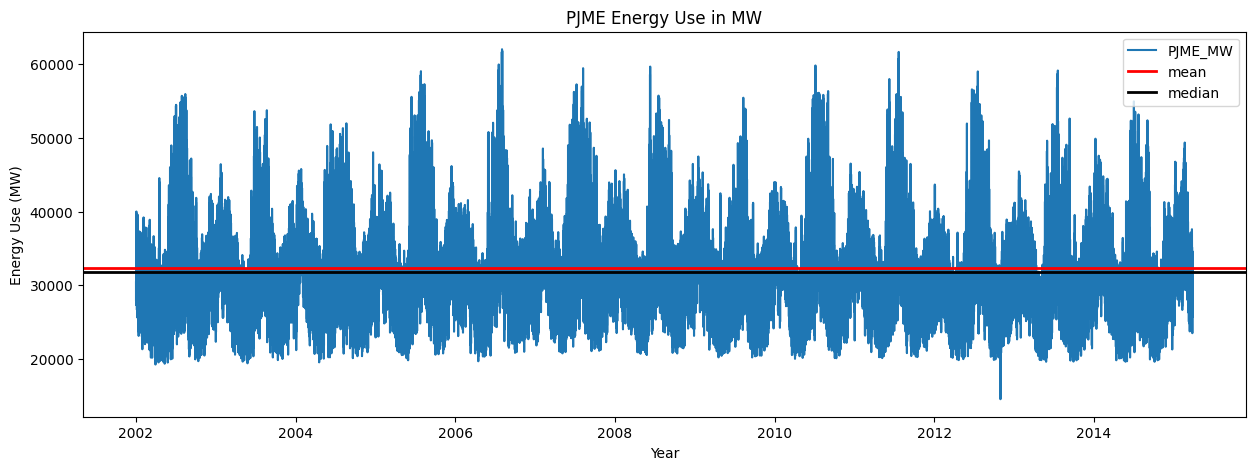

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))

plt.plot(train_df.index, train_df['PJME_MW'])

plt.axhline(y=np.nanmean(train_df['PJME_MW']), color = 'r', linewidth=2.0)
plt.axhline(y=np.nanmedian(train_df['PJME_MW']), color = 'k', linewidth=2.0)

plt.legend(['PJME_MW', 'mean', 'median'])
plt.xlabel('Year')
plt.ylabel('Energy Use (MW)')
plt.title('PJME Energy Use in MW')

plt.show()

#### Histogram

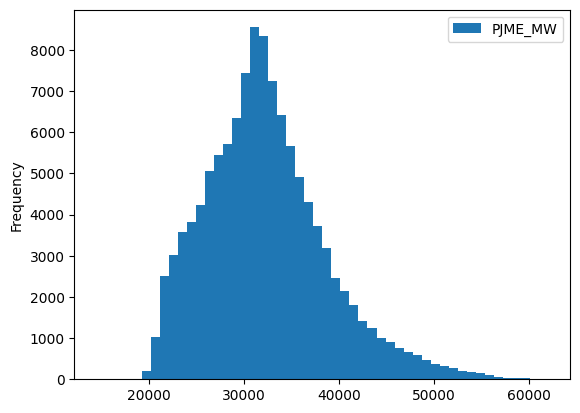

In [ ]:
train_df.plot(kind='hist', bins=50);

Our data in a tabular context is right skewed, so we will have to account for this in our modeling process assuming that this characteristic is not accounted for by trend components.

A right skew in this instance represents a pattern of the PjME MW data to have markedly more deviation in the power that is positive rather than negative. This is reflected above in our time series plot by Datetime, where the visual extreme fluctuation occurs more in a positive direction than it does in a negative direction.

The culmination of my basic analysis combined with visual intuition from the above time series plot and histogram suggests that there is power consumption behavior that seems to manifest in the form of spikes. In the model design process, we will have to figure out how to account for this behavior by making a distinction between trend, seasonal, and noise components of the spikes in the data in addition to the overall behavior of the data.

In [ ]:
train_df[train_df['PJME_MW'] < 20000]

,PJME_MW
2002-03-31 03:00:00,19447.0
2002-03-31 04:00:00,19247.0
2002-03-31 05:00:00,19258.0
2002-03-31 06:00:00,19725.0
2002-04-14 04:00:00,19674.0
...,...
2014-10-05 05:00:00,19637.0
2014-10-19 04:00:00,19846.0
2014-10-19 05:00:00,19822.0
2014-10-26 04:00:00,19952.0


In [ ]:
train_df[train_df['PJME_MW'] < 20000].shape[0] / train_df.shape[0]

0.001016838150388639

As you can see above, the overall mean energy consumption is greater than the median, which suggests that the data could be right skewed. Also, there seems to be much more variation above the mean/median lines than there is below, where there are almost no values that go very far below 20000 MW. Also, many of thee lower values seem to occur during either the same day, the same hour period (early morning) or a mixture of both. This suggests that hour will be an important variable to any model.

As an aside, there could be a baseline level of energy use could be artificially induced, as it could be the case that there is a baseline level of power provided to the grid regardless of if there is actually demand/consumption for it.

### Basic Feature Creation For More in Depth Analysis

In [ ]:
def create_features(input_df):
    df = input_df.copy()

    df['Datetime'] = df.index

    # data only goes down to by hour, so adding minutes or seconds is pointless.
    df['hour'] = df['Datetime'].dt.hour
    df['day'] = df['Datetime'].dt.day
    # The day of the week with Monday=0, Sunday=6.
    df['dayofweek'] = df['Datetime'].dt.dayofweek

    df["Dayofyear"] = df["Datetime"].dt.dayofyear
    df['weekofyear'] = df['Datetime'].dt.isocalendar().week

    df['weekofyear'] = df['weekofyear'].astype('int32')

    df['month'] = df['Datetime'].dt.month
    df['year'] = df['Datetime'].dt.year
    df["Quarter"] = df["Datetime"].dt.quarter

    df.drop(['Datetime'], axis=1, inplace=True)

    return df

In [ ]:
train_df = create_features(train_df)
train_df

,PJME_MW,hour,day,dayofweek,Dayofyear,weekofyear,month,year,Quarter
2002-01-01 01:00:00,30393.0,1,1,1,1,1,1,2002,1
2002-01-01 02:00:00,29265.0,2,1,1,1,1,1,2002,1
2002-01-01 03:00:00,28357.0,3,1,1,1,1,1,2002,1
2002-01-01 04:00:00,27899.0,4,1,1,1,1,1,2002,1
2002-01-01 05:00:00,28057.0,5,1,1,1,1,1,2002,1
...,...,...,...,...,...,...,...,...,...
2015-03-29 02:00:00,29284.0,2,29,6,88,13,3,2015,1
2015-03-29 03:00:00,28993.0,3,29,6,88,13,3,2015,1
2015-03-29 04:00:00,28918.0,4,29,6,88,13,3,2015,1
2015-03-29 05:00:00,29222.0,5,29,6,88,13,3,2015,1


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 116046 entries, 2002-01-01 01:00:00 to 2015-03-29 06:00:00
Freq: H
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   PJME_MW     116046 non-null  float64
 1   hour        116046 non-null  int32  
 2   day         116046 non-null  int32  
 3   dayofweek   116046 non-null  int32  
 4   Dayofyear   116046 non-null  int32  
 5   weekofyear  116046 non-null  int32  
 6   month       116046 non-null  int32  
 7   year        116046 non-null  int32  
 8   Quarter     116046 non-null  int32  
dtypes: float64(1), int32(8)
memory usage: 5.3 MB


### Unit Root and Stationarity Testing

https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/

https://machinelearningmastery.com/time-series-data-stationary-python/

https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html

https://medium.com/@tannyasharma21/comparision-study-of-adf-vs-kpss-test-c9d8dec4f62a#:~:text=ADF%20finds%20a%20unit%20root,it%20needs%20to%20be%20detrended.

#### ADF unit root test

Null Hypothesis (HO): Series is non-stationary, or series has a unit root.

Alternate Hypothesis(HA): Series is stationary, or series has no unit root

If Test statistic < Critical Value and p-value < 0.05 – Reject Null Hypothesis(HO).

In [ ]:
from statsmodels.tsa.stattools import adfuller

result_adf = adfuller(train_df['PJME_MW'])
print('ADF Statistic: %f' % result_adf[0])
print('p-value: %f' % result_adf[1])
print('Lags Used %f' % result_adf[2])
print('Critical Values:')
for key, value in result_adf[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -19.023686
p-value: 0.000000
Lags Used 71.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


According to ADF, we can reject the null, so the data is stationary.

#### KPSS test

Null Hypothesis (HO): Series is trend stationary or series has no unit root.

Alternate Hypothesis(HA): Series is non-stationary, or series has a unit root

If the Test Statistic < Critical Value and p-value <0.05 – Fail to Reject Null Hypothesis(HO), i.e., time series does not have a unit root, meaning it is trend stationary./

In [ ]:
from statsmodels.tsa.stattools import kpss

result_kpss = kpss(train_df['PJME_MW'])
print('KPSS Statistic: %f' % result_kpss[0])
print('p-value: %f' % result_kpss[1])
print('Lags Used %f' % result_kpss[2])
print('Critical Values:')
for key, value in result_kpss[3].items():
 print('\t%s: %.3f' % (key, value))

KPSS Statistic: 0.362512
p-value: 0.093314
Lags Used 151.000000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


According to KPSS, we cannot reject the null, so the data is stationary.

#### Interpreting the results and why Stationarity matters:

https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html

https://towardsdatascience.com/why-does-stationarity-matter-in-time-series-analysis-e2fb7be74454 (first paragraph)

In our case, ADF indicates stationarity, and KPSS indicates stationarity, so there is no need for differencing. This stationarity suggests that we should be able to model behavior over time and that the behavior over time is likely consistent. So, if there are trends or seasonality in the data, we should be able to model them for one period of time, and have that be reflective of another period of time.ty.

In [ ]:
plt.style.use("ggplot")

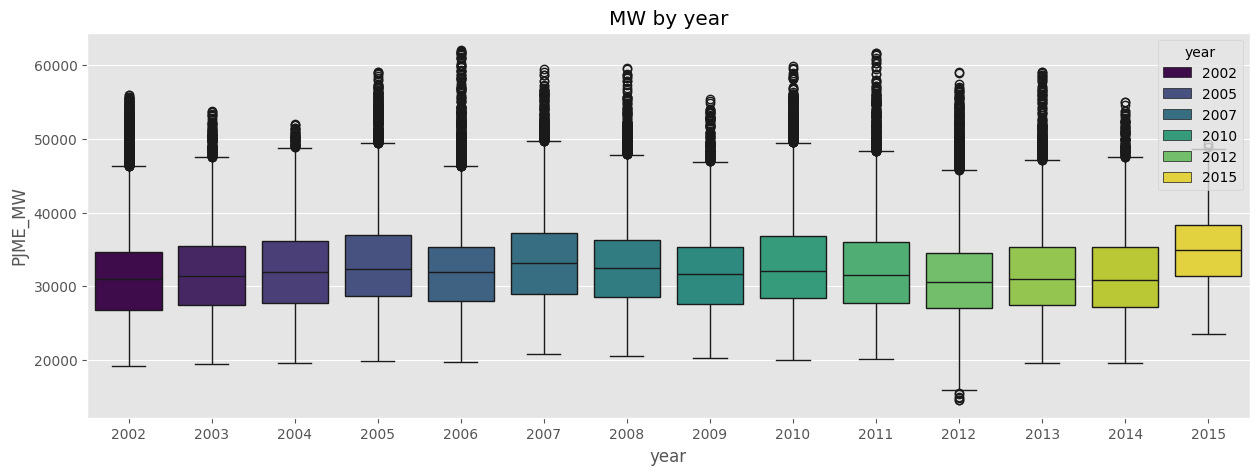

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=train_df, x='year', y='PJME_MW', hue='year', palette='viridis')
ax.set_title('MW by year')
plt.show()

There may be a small upward trend, however this set of boxplots doesn't visually portray a blatantly obvious trend.

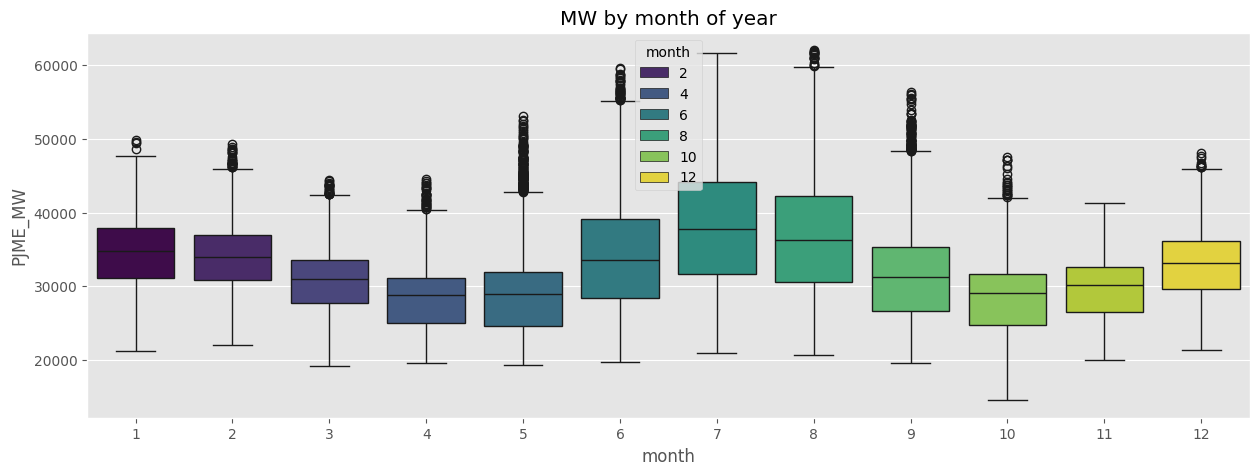

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=train_df, x='month', y='PJME_MW', hue='month', palette='viridis')
ax.set_title('MW by month of year')
plt.show()

There is definitely a monthly component to the data, which is a form of seasonality.

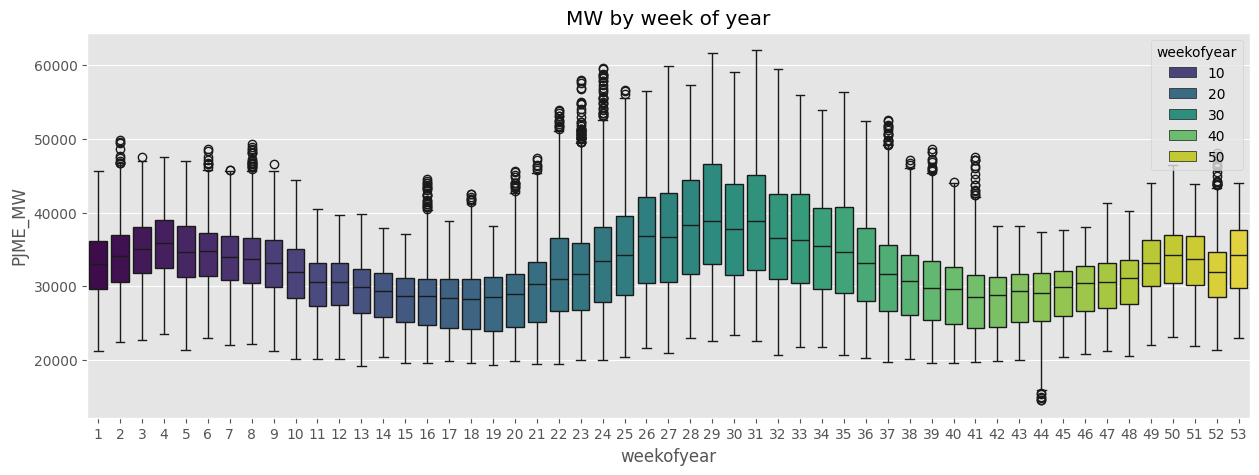

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=train_df, x='weekofyear', y='PJME_MW', hue='weekofyear', palette='viridis')
ax.set_title('MW by week of year')
plt.show()

There might be a weekly component, however I would say it looks extremely close to the moonthly component. They may be accounting for the same patterns.

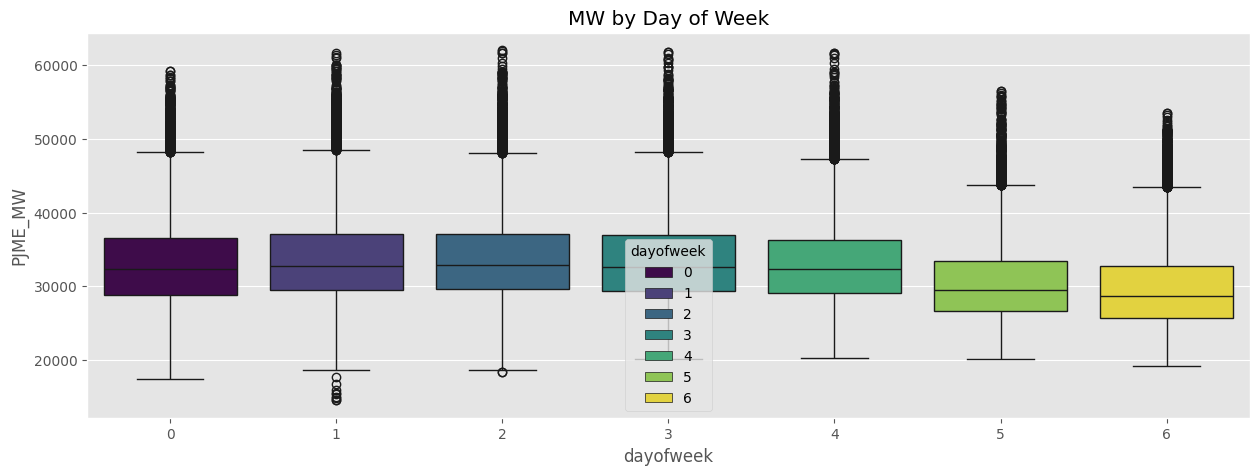

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=train_df, x='dayofweek', y='PJME_MW', hue='dayofweek', palette='viridis')
ax.set_title('MW by Day of Week')
plt.show()

The data varries based on if the day of the week is a weekend or is not a weekend. Saturday (5) and Sunday (6) are noticibly below the rest of the weekdays on median power consumption.

In [ ]:
train_df

,PJME_MW,hour,day,dayofweek,Dayofyear,weekofyear,month,year,Quarter
2002-01-01 01:00:00,30393.0,1,1,1,1,1,1,2002,1
2002-01-01 02:00:00,29265.0,2,1,1,1,1,1,2002,1
2002-01-01 03:00:00,28357.0,3,1,1,1,1,1,2002,1
2002-01-01 04:00:00,27899.0,4,1,1,1,1,1,2002,1
2002-01-01 05:00:00,28057.0,5,1,1,1,1,1,2002,1
...,...,...,...,...,...,...,...,...,...
2015-03-29 02:00:00,29284.0,2,29,6,88,13,3,2015,1
2015-03-29 03:00:00,28993.0,3,29,6,88,13,3,2015,1
2015-03-29 04:00:00,28918.0,4,29,6,88,13,3,2015,1
2015-03-29 05:00:00,29222.0,5,29,6,88,13,3,2015,1


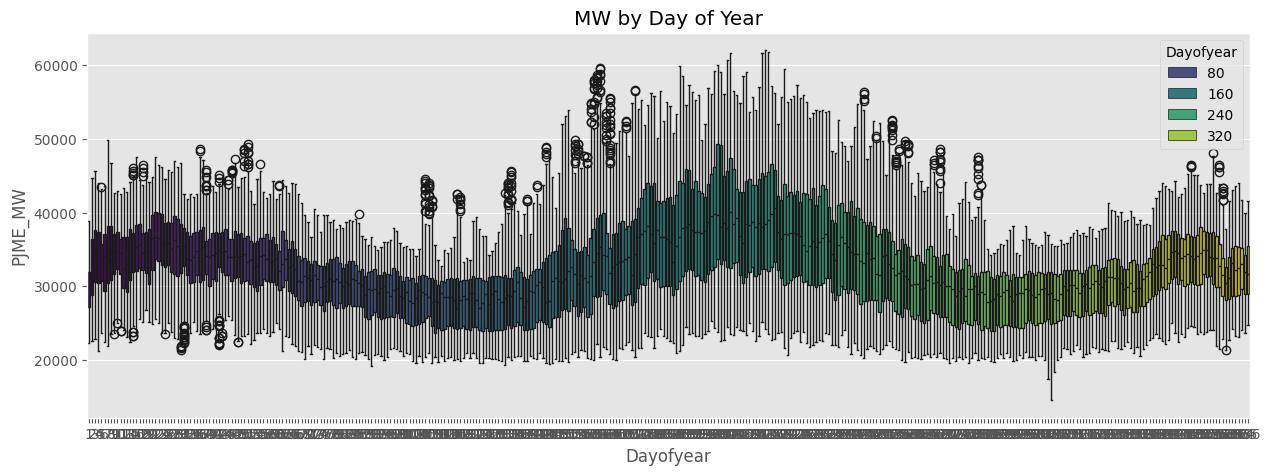

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))

sns.boxplot(data=train_df, x='Dayofyear', y='PJME_MW', hue='Dayofyear', palette='viridis')
ax.set_title('MW by Day of Year')
plt.show()

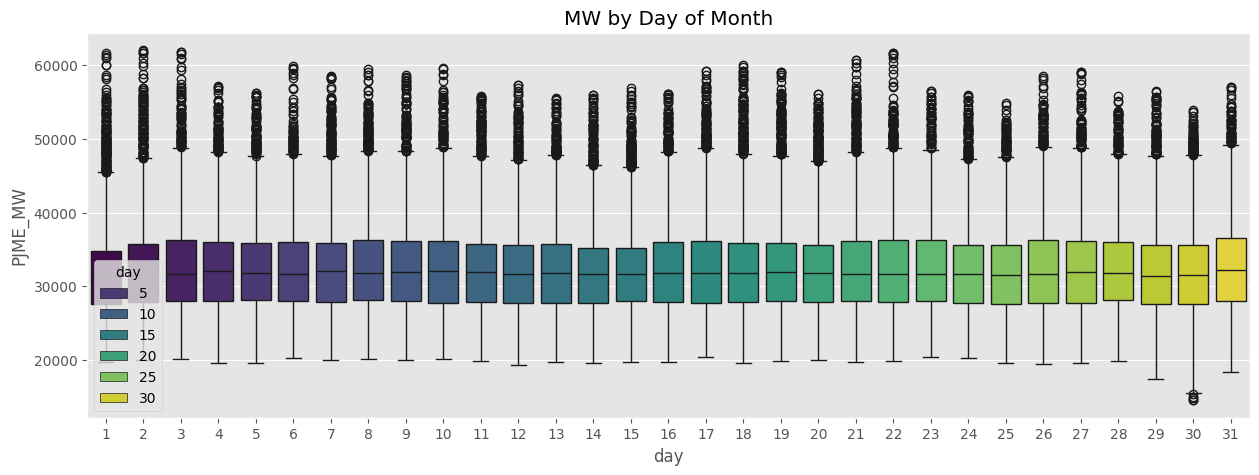

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=train_df, x='day', y='PJME_MW', hue='day', palette='viridis')
ax.set_title('MW by Day of Month')
plt.show()

Across days of the month, the data does not seem to have any blatant seasonality either.

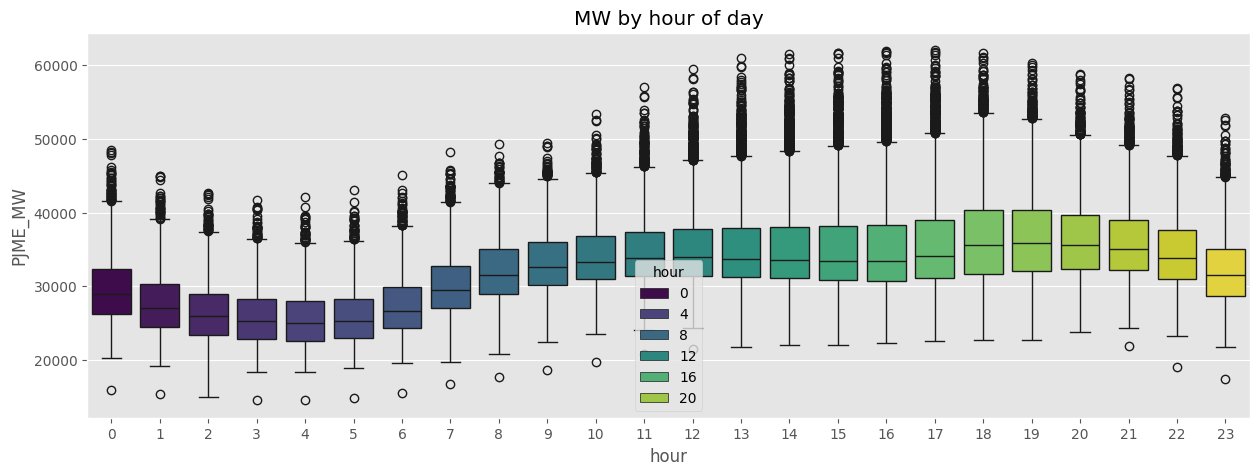

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=train_df, x='hour', y='PJME_MW', hue='hour', palette='viridis')
ax.set_title('MW by hour of day')
plt.show()

Across hours, there is an obvious period of peaking and valleying in the data. Energy use begins the day at a decrease, decreases until is at a low in the early hours of the morning at about 4 o'clock in the morning, increases sharply for the next 7 hours, and then increases gradually until it peaks at about 7pm, after which it begins to drop sharply back into the valley for the next day.

To me, this indicates that the month, weekday, and hour will be the strongest components in any model utilizing only the power consumption and date time data. Weekday could potentially be converted into a boolean in the form of a check if the given day is a weekend or is not.

## Correlation Measurements

In [ ]:
train_df.head()

,PJME_MW,hour,day,dayofweek,Dayofyear,weekofyear,month,year,Quarter
2002-01-01 01:00:00,30393.0,1,1,1,1,1,1,2002,1
2002-01-01 02:00:00,29265.0,2,1,1,1,1,1,2002,1
2002-01-01 03:00:00,28357.0,3,1,1,1,1,1,2002,1
2002-01-01 04:00:00,27899.0,4,1,1,1,1,1,2002,1
2002-01-01 05:00:00,28057.0,5,1,1,1,1,1,2002,1


In [ ]:
train_df.columns[:9]

Index(['PJME_MW', 'hour', 'day', 'dayofweek', 'Dayofyear', 'weekofyear',
       'month', 'year', 'Quarter'],
      dtype='object')

In [ ]:
# get all numerical columns
numerical_features = train_df.columns[:9]

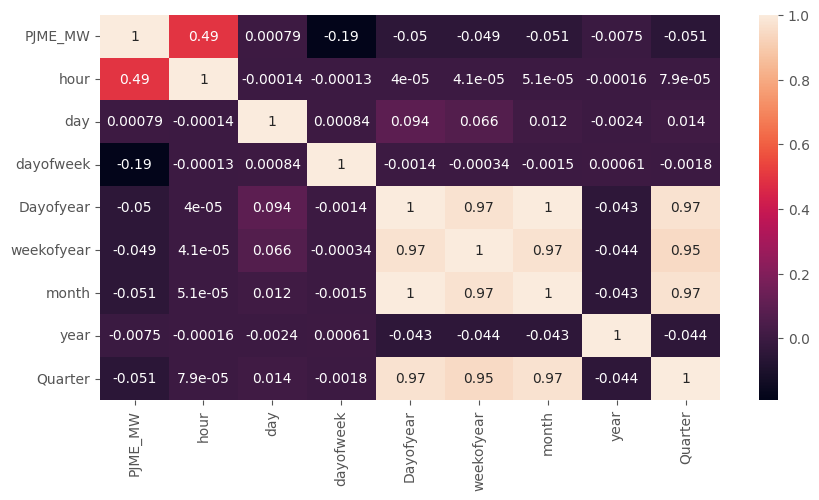

In [ ]:
fig = plt.subplots(figsize=(10,5))
sns.heatmap(train_df[numerical_features].corr(), annot=True)
plt.show()

One important factor to remember about correlation is that it only accounts for linear relationships; it cannot accurately measure non-linear relationships. So, for example, despite the fact that above, visually, month has a strong wave-like relationship with the PJME_MW value, in the correlation heatmap it only has a value of -0.051. Interestingly, despite this fact, hour still has a strong positive correlation with PJME_MW. The fact that we can visually observe that hour has a non-linear (similar to month actually) wave like relationship with PJME_MW is just another indicator of how relevant it will likely be as a variable during the model building process.

### Autocorrelation of PJME_MW at the hourly level

https://www.kaggle.com/code/iamleonie/time-series-interpreting-acf-and-pacf

Autocorrelation and Partial autocorrelation are measurements of a variable's correlation to its own lagged values. Autocorrelation is a correlation with a variable's own laged values. Partial autocorrelation is a correlation with a variable's own lagged value residuals between the current value and the lagged value. Autocorrelation measures overall effect, while partial autocorrelation measure direct effect.


Regular and Parital autocorrelation at the day level. Examination across 2 days with hour lags.

1. From 1 to 23, the lags represent correlation to the 23 hours prior to the current hour.

2. At 24 hours, the lag corresponds to the same hour 1 day prior.

3. At 25-47 hours, the lags represent correlation to the previous day's previous 23 hours.

4. At 48 hours, the lag represents the same hour 2 days prior.

In [ ]:
import statsmodels.api as sm

#### Autocorrelation

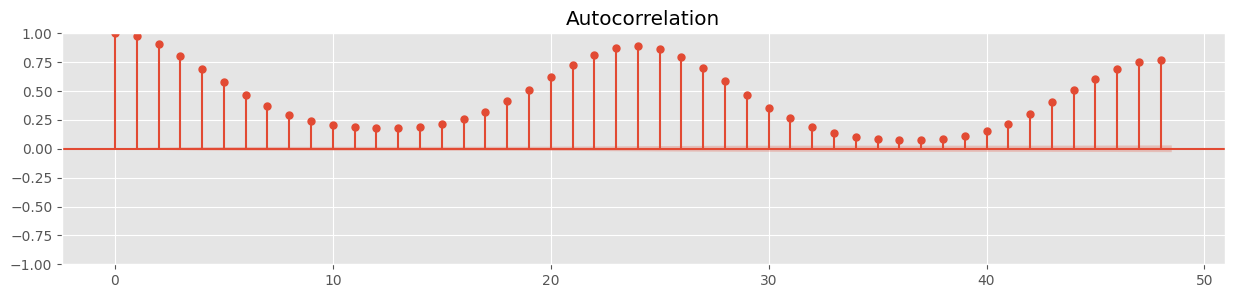

In [ ]:
fig, ax = plt.subplots(figsize=(15, 3))

# 24 hours * 2 days = 48 hours or 2 days of lags
sm.graphics.tsa.plot_acf(train_df['PJME_MW'], lags=24 * 2, ax=ax)

plt.show()

There is an obvious pattern in the autocorrelation here. The autocorrelation starts high (indicating that hours close to the current hour are correlated at a decreasing rate until a local minimum around 12-14 hours prior, where it starts to increase again until it peaks at exactly 24 hours prior, which is the same hour. This means that there is a daily seasonality in the data and that we should include hour lags in the future models.

#### Partial Autocorrelation

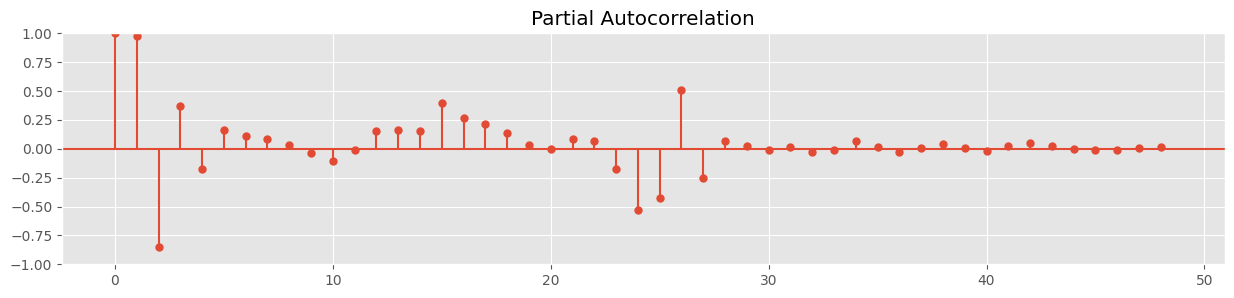

In [ ]:
fig, ax = plt.subplots(figsize=(15, 3))

# 24 hours * 2 days = 48 hours or 2 days of lags
sm.graphics.tsa.plot_pacf(train_df['PJME_MW'], lags=24 * 2, ax=ax)

plt.show()

#### Ljung-Box Test

In [ ]:
sm.stats.acorr_ljungbox(train_df['PJME_MW'], lags=[24*2], return_df=True)

,lb_stat,lb_pvalue
48,1.502335e+06,0.0


So, here, there is a pattern in the autocorrelation, which has values that are all outside of the confidence band, and multiple places where partial autocorrelation is far outside of any confidence band as well. Also, the the Ljung-Box Test test result p-value is 0, which is also below the threshold required to reject the null (< 0.05 for 95% confidence) that the variable has no serial correlation with its lags. My conclusions from above are that hours is a variable that is both relevant to predictions and deserves to have its lags included in future models.

From the above autocorrelation plots, we can tell that the hourly value of PJME is heavily correlated to lagged examples of PJME. This means that it is probably a good idea to include lagged hourly values in future models.

### Time Series STL Decomposition

STL decomposition can account for changes in seasonality over time. I will examine at an hourly and monthly level the ability for STL decomposition. As hour and month have the highest impact visually, I will perform STL decomposition at these levels.

Because there is no obvious trend in the model of an increase or decrease in seasonality, I will use additive decomposition via STL decomposition. I will aggregate the data by monthly average in order to smooth it out.

In [ ]:
from statsmodels.tsa.seasonal import STL

In [ ]:
#pip install matplotlib --upgrade --user
#pip install seaborn --upgrade --user
#pip install statsmodels --upgrade --user

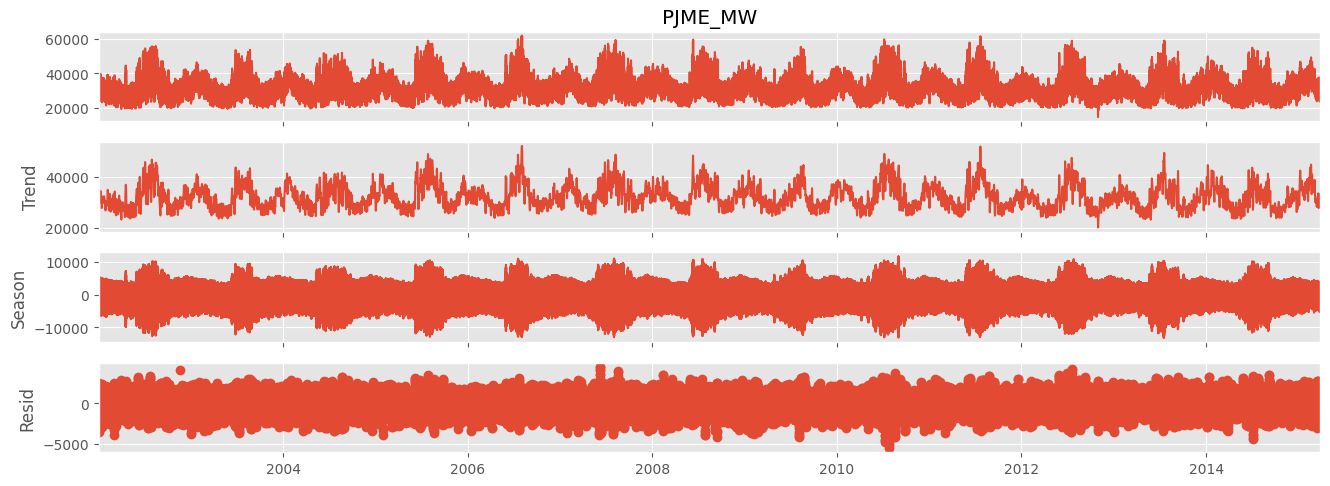

In [ ]:
# m = 24 hours in a single day
stl1 = STL(train_df['PJME_MW'], period=24)
results_stl1 = stl1.fit()

trend_stl1 = results_stl1.trend
seasonal_stl1 = results_stl1.seasonal
residuals_stl1 = results_stl1.resid

fig = results_stl1.plot()
fig.set_size_inches((15, 5))

plt.show()

I can't really tell much about the seasonality at a high level from this decomposition, however I can tell that there doesn't seem to be an obvious trend. I will aggregate by month now and use the average value.

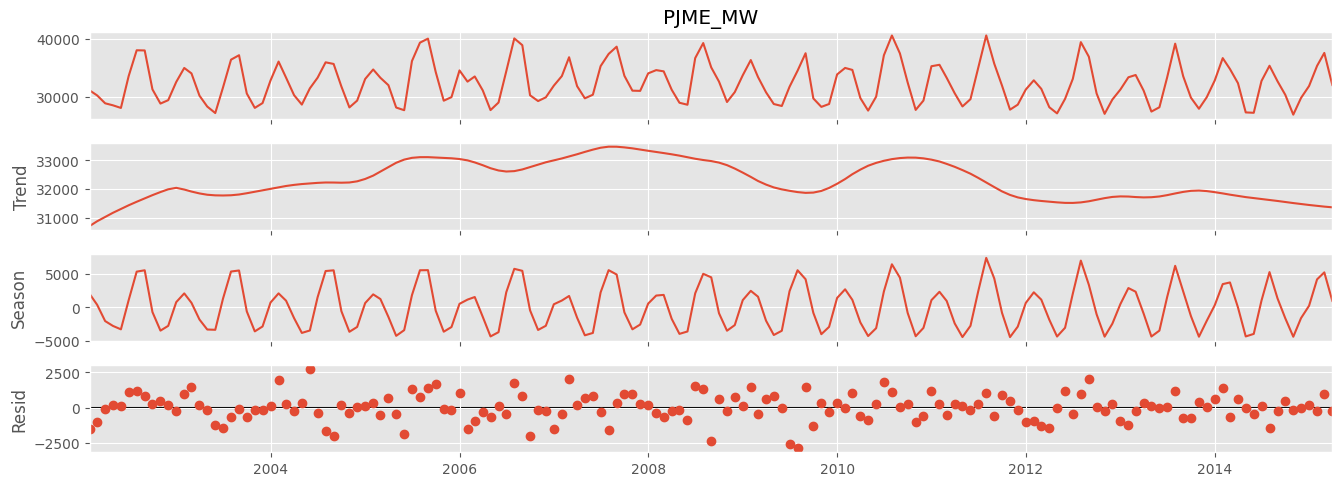

In [ ]:
monthly_power_mean = train_df.resample('1m', origin=train_df.index[0])['PJME_MW'].mean()
monthly_power_mean

# m = 12 months in a single year
stl2 = STL(monthly_power_mean, period=12)
results_stl2 = stl2.fit()

trend_stl2 = results_stl2.trend
seasonal_stl2 = results_stl2.seasonal
residuals_stl2 = results_stl2.resid

fig = results_stl2.plot()
fig.set_size_inches((15, 5))

plt.show()

Even smoothed by monthly average, there is no overtly discernable trend component in the data, which means that most of the prediction accuracy that we can gain will likely rely on seasonality. This decomposition is at a monthly level and within 12 periods (12 months in a year), and it shows that there is an obvious seasonality in the data at the monthly aggregation level, which helps to confirm my suspicions from above that despite monthly not having a high correlation value, that it is likely a valuable variable to include in future models. I imagine the quarter might capture some of this relationship as well, albiet at a lower resolution.

# Establishing K-fold cross validation for Time Series

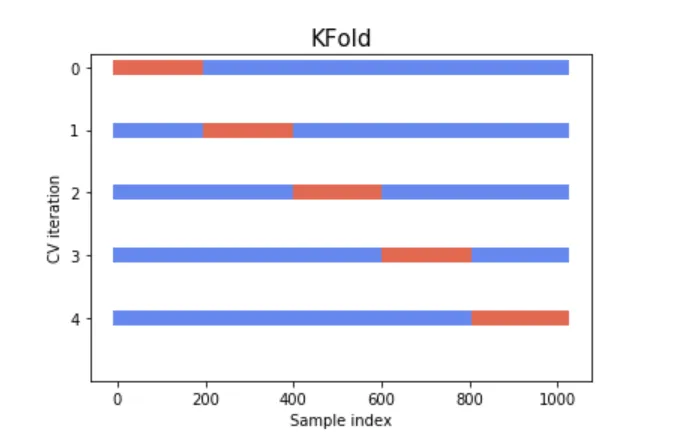

source: https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4

This is basically what our cross validation looks like, except rather than labeling the test set as test data, we label as validation data, because we already defined our test set.

In [ ]:
# this is K-fold cross validation for the time series
from sklearn.model_selection import TimeSeriesSplit

def k_fold_cv_ts(input_df, n_splits=2):
    tscv = TimeSeriesSplit(n_splits=n_splits)

    train_sets = []
    validation_sets = []

    # build sets for the train and validation data from the indexes provided by TimeSeriesSplit()
    for train_index, test_index in tscv.split(input_df):
        train_sets.append(input_df.iloc[train_index].copy())
        validation_sets.append(input_df.iloc[test_index].copy())

    # build X, y train and X, y validation sets for testing

    X_train_l = []
    y_train_l = []
    X_validation_l = []
    y_validation_l = []

    # first column value must by 'y'

    y_column = input_df.columns[0]

    for i in range(len(train_sets)):
        # seperate y train from X train
        X_train_l.append(train_sets[i].drop(labels=[y_column], axis=1))
        y_train_l.append(train_sets[i][y_column])

        # seperate y validation from X validation
        X_validation_l.append(validation_sets[i].drop(labels=[y_column], axis=1))
        y_validation_l.append(validation_sets[i][y_column])


    return([X_train_l, y_train_l, X_validation_l, y_validation_l])

In [ ]:
X_train_l, y_train_l, X_validation_l, y_validation_l = k_fold_cv_ts(train_df, n_splits=4)

In [ ]:
for i in range(len(X_train_l)):

    current_train_prop = X_train_l[i].shape[0] / train_df.shape[0]
    current_validation_prop = X_validation_l[i].shape[0] / train_df.shape[0]

    print(f"Fold [{i + 1}] Train set proportion : {round(current_train_prop, 4) * 100}%")
    print(f"Fold [{i + 1}] Validation set proportion: {round(current_validation_prop, 4) * 100}%")
    print('')

Fold [1] Train set proportion : 20.0%
Fold [1] Validation set proportion: 20.0%

Fold [2] Train set proportion : 40.0%
Fold [2] Validation set proportion: 20.0%

Fold [3] Train set proportion : 60.0%
Fold [3] Validation set proportion: 20.0%

Fold [4] Train set proportion : 80.0%
Fold [4] Validation set proportion: 20.0%



## IMPORTANT NOTE:
Anything in the model building and examination process that has a variable label or descriptor that involves the word 'test' is NOT refering to data within the test_df data. The variables containing data below this point will all be subsets until a specified section at the end.


We now have our k-fold cross validation for time series. In order to prepare the data a bit further for modeling, we need to do a few other things before we can get our actual end data for our train / validatoin splits. Even if we end up chosing not to use each of the k-fold splits (and just go with the 80% / 20% split), it is useful to have.

# More Data Prep and Division of Models

Some models require different data processing proceedures, libraries, etc. Here is where we will import everything that we need.

In [ ]:
#!pip install tensorflow
#!pip install meteostat
#!pip install prophet

In [ ]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import sklearn.preprocessing

from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from prophet import Prophet
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, LSTM
from tensorflow.keras.models import Sequential
from meteostat import Hourly, Stations
from datetime import datetime

## Important: For the following models, we will be using the following function:

In [ ]:
X_train_l, y_train_l, X_validation_l, y_validation_l = k_fold_cv_ts(train_df, n_splits=4)

### We will use the final (4th) fold indexed at [3], which splits the current train data into train and validation sets

In [ ]:
X_train = X_train_l[3]

y_train = y_train_l[3]

X_validation = X_validation_l[3]

y_validation = y_validation_l[3]

### Reasoning:

We will use the final fold; where the least recent 80% of the current train set data will remain train set data, and the most recent 20% of the current train set data will be used as validation data.

We can chose if we want to run our models through every set of k-fold cross validation or not, perhaps based on whichever one seems most promising (as the train process can be time consuming).

# Model #1 - Prophet
* How model works: We utilizes a simple Prophet model that takes the training period in as an input (2002 to 2015) and predicts the MW values for the subsequent test period (2015 to 2018)
* Performance metrics of model:
  * RMSE: 4634.67
  *
R2 Score: 0.43

In [ ]:
prophet_train = pd.DataFrame(y_train)
prophet_train['ds'] = prophet_train.index
prophet_train["y"] = prophet_train["PJME_MW"]

prophet_train

,PJME_MW,ds,y
2002-01-01 01:00:00,30393.0,2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0,2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0,2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0,2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0,2002-01-01 05:00:00,28057.0
...,...,...,...
2012-08-04 01:00:00,35569.0,2012-08-04 01:00:00,35569.0
2012-08-04 02:00:00,33333.0,2012-08-04 02:00:00,33333.0
2012-08-04 03:00:00,31733.0,2012-08-04 03:00:00,31733.0
2012-08-04 04:00:00,30602.0,2012-08-04 04:00:00,30602.0


In [ ]:
prophet_test = pd.DataFrame(y_validation)
prophet_test['ds'] = prophet_test.index
prophet_test["y"] = prophet_test["PJME_MW"]

prophet_test

,PJME_MW,ds,y
2012-08-04 06:00:00,30131.0,2012-08-04 06:00:00,30131.0
2012-08-04 07:00:00,30448.0,2012-08-04 07:00:00,30448.0
2012-08-04 08:00:00,32367.0,2012-08-04 08:00:00,32367.0
2012-08-04 09:00:00,35696.0,2012-08-04 09:00:00,35696.0
2012-08-04 10:00:00,39292.0,2012-08-04 10:00:00,39292.0
...,...,...,...
2015-03-29 02:00:00,29284.0,2015-03-29 02:00:00,29284.0
2015-03-29 03:00:00,28993.0,2015-03-29 03:00:00,28993.0
2015-03-29 04:00:00,28918.0,2015-03-29 04:00:00,28918.0
2015-03-29 05:00:00,29222.0,2015-03-29 05:00:00,29222.0


In [ ]:
# Create prophet model using the training data
prophet_model = Prophet(interval_width=0.80)
prophet_model.fit(prophet_train)

08:35:53 - cmdstanpy - INFO - Chain [1] start processing
08:36:50 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
prophet_start_date = prophet_test.index.min()
prophet_end_date = prophet_test.index.max()

# Calculate the number of hours between the last train date and the last available date
prophet_forecast_horizon = (prophet_end_date - prophet_start_date).total_seconds() / 3600  # convert seconds to hours

# Adjust this to an integer if needed (though it should already be an integer if data are hourly)
prophet_forecast_horizon = int(prophet_forecast_horizon)

# Create a future dataframe that covers the test data range
prophet_future_dates = prophet_model.make_future_dataframe(periods=prophet_forecast_horizon, freq='H')

In [ ]:
# Predict over the future dataframe
prophet_forecast = prophet_model.predict(prophet_future_dates)

In [ ]:
# Display the forecast; you might want to join this with the actual values to compare performance
prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2002-01-01 01:00:00,25763.565010,21223.862678,30035.086668
1,2002-01-01 02:00:00,24261.998366,19856.068593,28901.287458
2,2002-01-01 03:00:00,23395.838135,18655.662538,27923.767544
3,2002-01-01 04:00:00,23255.594288,18743.554100,27592.896725
4,2002-01-01 05:00:00,23927.116908,19587.422646,28286.861612


In [ ]:
prophet_test

,PJME_MW,ds,y
2012-08-04 06:00:00,30131.0,2012-08-04 06:00:00,30131.0
2012-08-04 07:00:00,30448.0,2012-08-04 07:00:00,30448.0
2012-08-04 08:00:00,32367.0,2012-08-04 08:00:00,32367.0
2012-08-04 09:00:00,35696.0,2012-08-04 09:00:00,35696.0
2012-08-04 10:00:00,39292.0,2012-08-04 10:00:00,39292.0
...,...,...,...
2015-03-29 02:00:00,29284.0,2015-03-29 02:00:00,29284.0
2015-03-29 03:00:00,28993.0,2015-03-29 03:00:00,28993.0
2015-03-29 04:00:00,28918.0,2015-03-29 04:00:00,28918.0
2015-03-29 05:00:00,29222.0,2015-03-29 05:00:00,29222.0


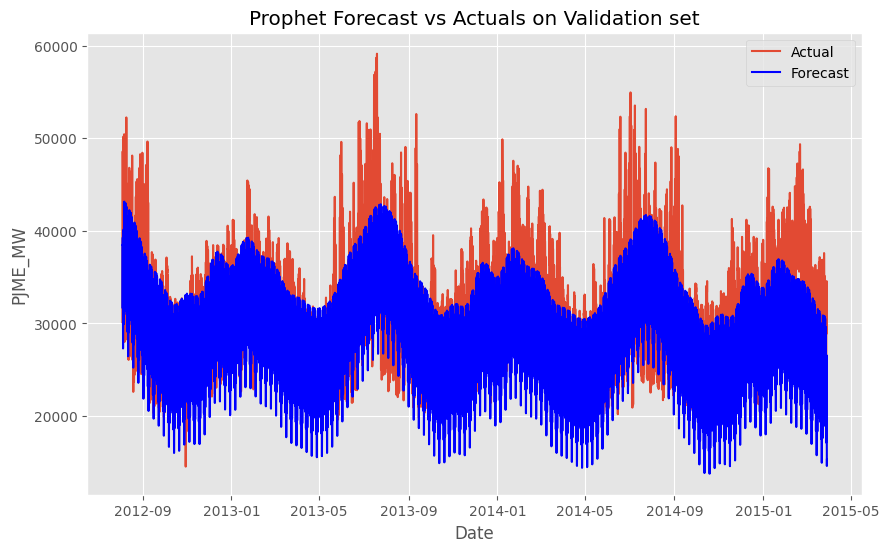

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Assuming test_data is prepared with a 'Datetime' index and a single target column 'PJME_MW'
prophet_test['forecast'] = prophet_forecast.set_index('ds')['yhat'].reindex(prophet_test.index)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(prophet_test["ds"], prophet_test['PJME_MW'], label='Actual')
plt.plot(prophet_test["ds"], prophet_test['forecast'], color='b', label='Forecast')
plt.title('Prophet Forecast vs Actuals on Validation set')
plt.xlabel('Date')
plt.ylabel('PJME_MW')
plt.legend()
plt.show()

In [ ]:
# Calculate RMSE and R2
rmse = np.sqrt(mean_squared_error(prophet_test.dropna()['PJME_MW'], prophet_test.dropna()['forecast']))
r2 = r2_score(prophet_test.dropna()['PJME_MW'], prophet_test.dropna()['forecast'])
print(f'RMSE: {round(rmse,2)}')
print(f'R2 Score: {round(r2,4)}')

RMSE: 4634.67
R2 Score: 0.43


# Model #2 - LSTM (time only)
* How model works:
* Performance metrics of model:
  * Mean R2
  * MSE

In [ ]:
LSTM_train = pd.DataFrame(y_train)
LSTM_test =  pd.DataFrame(y_validation)

## MinMaxScaler

In [ ]:
# this function was made in case it does matter if you apply the scaler seperately

def scale_merge_preserve_split(train_df, test_df):

    df1_length = train_df.shape[0]

    scale_df = pd.concat([train_df, test_df])

    # Normalize the feature(s)
    mw_scaler = MinMaxScaler()
    scale_df['scaled'] = mw_scaler.fit_transform(scale_df[['PJME_MW']].values)

    df1_scaled = scale_df.iloc[:df1_length]
    df2_scaled = scale_df.iloc[df1_length:]

    return([df1_scaled, df2_scaled, mw_scaler])

In [ ]:
LSTM_train, LSTM_test, LSTM_mw_scaler = scale_merge_preserve_split(LSTM_train, LSTM_test)

Now to create weekly sequences, as we will use LSTM to predict weekly.

In [ ]:
def create_sequences(train_df, test_df, n_steps_in, n_steps_out):

    X = []
    y = []

    # aggregate the data together in chronoglocial order
    sequence_df = pd.concat([train_df, test_df])

    # Reshape the dataset suitable for the LSTM model
    sequence_df = sequence_df['scaled'].values.reshape(-1, 1)

    # find total number of hours in data
    total_hours = sequence_df.shape[0]

    for i in range(total_hours - n_steps_in - n_steps_out + 1):

        X.append(sequence_df[i:(i + n_steps_in), 0])
        y.append(sequence_df[(i + n_steps_in):(i + n_steps_in + n_steps_out), 0])

    X = np.array(X)
    y = np.array(y)

    # Split data back into train and test sets
    split_point = len(train_df)

    X_train, X_test = X[:split_point], X[split_point:]
    y_train, y_test = y[:split_point], y[split_point:]

    #
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    return [X_train, y_train, X_test, y_test]

    return [np.array(X), np.array(y)]

# Example settings
n_steps_in, n_steps_out = 24*7, 24*7  # Use previous 7 days in hours to predict the next 7 days in hours

LSTM_train_X, LSTM_train_y, LSTM_test_X, LSTM_test_y = create_sequences(LSTM_train, LSTM_test, n_steps_in, n_steps_out)

In [ ]:
LSTM_model = Sequential()
# First LSTM layer with dropout
LSTM_model.add(LSTM(50, activation='tanh', return_sequences=True, input_shape=(n_steps_in, 1)))
LSTM_model.add(Dropout(0.2))  # Adding 20% dropout

# Second LSTM layer
LSTM_model.add(LSTM(16, activation='tanh'))
LSTM_model.add(Dropout(0.2))  # Adding 20% dropout

# Output layer
LSTM_model.add(Dense(n_steps_out))

LSTM_model.compile(optimizer='adam', loss='mse')

In [ ]:
# Fit the model
history_LSTM = LSTM_model.fit(
                              LSTM_train_X, LSTM_train_y,
                              epochs=1, # make 20 for final run
                              batch_size=64,
                              validation_split=0.1,
                              verbose=1
)

1306/1306 ━━━━━━━━━━━━━━━━━━━━ 82s 63ms/step - loss: 0.0086 - val_loss: 0.0062


In [ ]:
y_pred_LSTM = LSTM_model.predict(LSTM_test_X)

715/715 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step


In [ ]:
y_pred_LSTM

array([[0.32281932, 0.34607473, 0.37537333, ..., 0.30769032, 0.2988977 ,
        0.29681835],
       [0.3404323 , 0.3734551 , 0.41024432, ..., 0.29110008, 0.29378387,
        0.303952  ],
       [0.36635366, 0.40545627, 0.4462192 , ..., 0.28739232, 0.3005076 ,
        0.32141715],
       ...,
       [0.25017005, 0.25928652, 0.2691647 , ..., 0.2700091 , 0.27504724,
        0.27778292],
       [0.2559141 , 0.266944  , 0.27820566, ..., 0.2681299 , 0.27645934,
        0.2821261 ],
       [0.26383248, 0.2758731 , 0.28761655, ..., 0.26981258, 0.281125  ,
        0.2891883 ]], dtype=float32)

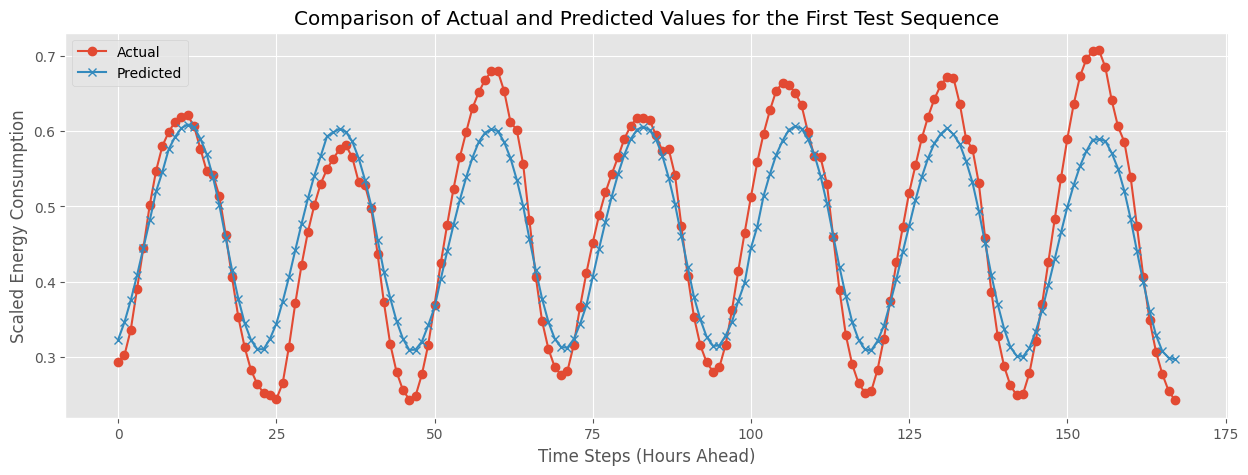

In [ ]:
# Example visualization: Compare the first predicted week to the actual data
plt.figure(figsize=(15, 5))
plt.plot(LSTM_test_y[0], label='Actual', marker='o')
plt.plot(y_pred_LSTM[0], label='Predicted', marker='x')
plt.title('Comparison of Actual and Predicted Values for the First Test Sequence')
plt.xlabel('Time Steps (Hours Ahead)')
plt.ylabel('Scaled Energy Consumption')
plt.legend()
plt.show()

In [ ]:
# Reshape y_pred and y_test to fit scaler's expected shape
y_pred_LSTM_rescaled = LSTM_mw_scaler.inverse_transform(y_pred_LSTM.reshape(-1, 1))
y_test_LSTM_rescaled = LSTM_mw_scaler.inverse_transform(LSTM_test_y.reshape(-1, 1))

# If y_test was reshaped during preprocessing, reshape it back for metrics calculation
y_pred_LSTM_rescaled = y_pred_LSTM_rescaled.reshape(y_pred_LSTM.shape)
y_test_LSTM_rescaled = y_test_LSTM_rescaled.reshape(LSTM_test_y.shape)

## Metrics

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

mse_LSTM = mean_squared_error(y_test_LSTM_rescaled, y_pred_LSTM_rescaled)
rmse_LSTM = np.sqrt(mse_LSTM)
r2_LSTM = r2_score(y_test_LSTM_rescaled, y_pred_LSTM_rescaled)

print("Mean Squared Error:", mse_LSTM)
print("Mean Squared Error:", rmse_LSTM)
print("R² Score:", r2_LSTM)

Mean Squared Error: 15437718.936386645
Mean Squared Error: 3929.0862724540225
R² Score: 0.5835295030651835


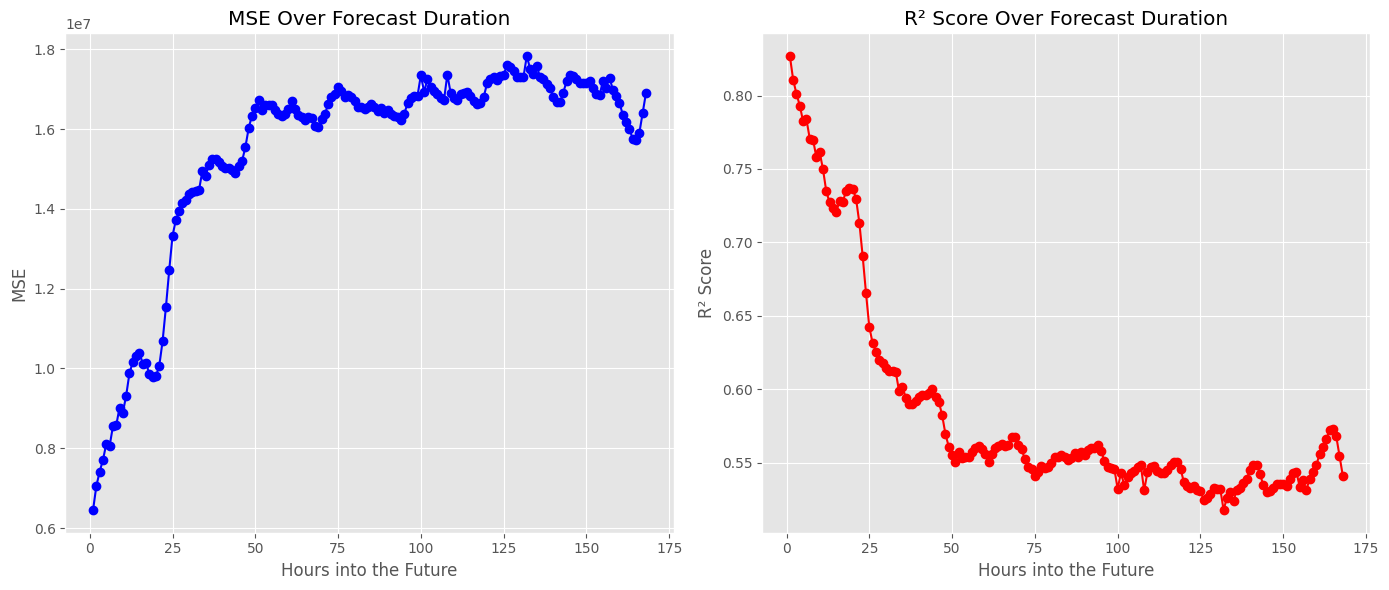

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate MSE and R2 for each forecast hour
mse_scores_LSTM = [mean_squared_error(y_test_LSTM_rescaled[:, i], y_pred_LSTM_rescaled[:, i]) for i in range(y_pred_LSTM_rescaled.shape[1])]
r2_scores_LSTM = [r2_score(y_test_LSTM_rescaled[:, i], y_pred_LSTM_rescaled[:, i]) for i in range(y_pred_LSTM_rescaled.shape[1])]

# Plotting the results
hours_LSTM = np.arange(1, y_pred_LSTM_rescaled.shape[1] + 1)
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(hours_LSTM, mse_scores_LSTM, marker='o', linestyle='-', color='b')
plt.title('MSE Over Forecast Duration')
plt.xlabel('Hours into the Future')
plt.ylabel('MSE')

plt.subplot(1, 2, 2)
plt.plot(hours_LSTM, r2_scores_LSTM, marker='o', linestyle='-', color='r')
plt.title('R² Score Over Forecast Duration')
plt.xlabel('Hours into the Future')
plt.ylabel('R² Score')

plt.tight_layout()
plt.show()

# Model #3 - LSTM (time + historical temp)
* How model works:
* Performance metrics of model:
  * Mean R2
  * MSE

In [ ]:
from meteostat import Hourly, Stations
from datetime import datetime

In [ ]:
def find_stations_by_location(locations):
    stations_info = {}

    for utility, loc in locations.items():
        # Find nearby weather stations
        stations = Stations()
        stations = stations.nearby(loc['latitude'], loc['longitude'])
        station = stations.fetch(1)  # Fetch top station

        if not station.empty:
            # Assume the first station is the closest
            stations_info[utility] = station.iloc[0].to_dict()

    return stations_info

# Dictionary mapping utility names to their representative city's latitude and longitude
locations = {
    'AP': {'city': 'Atlantic', 'latitude': 39.3766109, 'longitude': -74.452823},
    # 'JCPL': {'city': 'Lakehurst', 'latitude': 40.0128848, 'longitude': -74.354106},
    # 'DPL': {'city': 'Salisbury', 'latitude': 38.377498, 'longitude': -75.6313444},
    # 'PECO': {'city': 'Philadelphia', 'latitude': 40.0026438, 'longitude': -75.2831798},
    # 'PPL': {'city': 'Allentown', 'latitude': 40.5931353, 'longitude': -75.5251054},

}

stations_info = find_stations_by_location(locations)

In [ ]:
stations_info

{'AP': {'name': 'Atlantic City International',
  'country': 'US',
  'region': 'NJ',
  'wmo': '72407',
  'icao': 'KACY',
  'latitude': 39.4667,
  'longitude': -74.0833,
  'elevation': 23.0,
  'timezone': 'America/New_York',
  'hourly_start': Timestamp('1947-01-01 00:00:00'),
  'hourly_end': Timestamp('2024-04-24 00:00:00'),
  'daily_start': Timestamp('1947-01-01 00:00:00'),
  'daily_end': Timestamp('2024-12-30 00:00:00'),
  'monthly_start': Timestamp('1947-01-01 00:00:00'),
  'monthly_end': Timestamp('2022-01-01 00:00:00'),
  'distance': 33284.257665514415}}

In [ ]:
def get_weather_features(utility_name):
    # Prepare an empty DataFrame to hold all weather data

    weather_features = pd.DataFrame()

    location = locations[utility_name]

    # Get lat and lot
    latitude = location['latitude']
    longitude = location['longitude']

    # Find the nearest station
    stations = Stations()
    stations = stations.nearby(latitude, longitude)
    station = stations.fetch(1)

    # Get hourly data for the station
    start = min(pjme_data.index)
    end = max(pjme_data.index)
    weather_data = Hourly(station['wmo'][0], start, end)
    weather_data = weather_data.fetch()

    # Convert temperature to Fahrenheit
    weather_data['temp'] = weather_data['temp'] * 9/5 + 32
    weather_data = weather_data[['temp']]

    # Generate a complete datetime range
    full_range = pd.date_range(start=weather_data.index.min(), end=weather_data.index.max(), freq='H')

    # Reindex the DataFrame to include all hourly intervals
    weather_data = weather_data.reindex(full_range)

    # Interpolate missing values linearly
    weather_data.interpolate(method='linear', inplace=True)

    # Rename the temperature column to include the utility name
    weather_data.rename(columns={'temp': f'temp_{utility_name}'}, inplace=True)


    return weather_data

In [ ]:
# Create an empty DataFrame for all weather data
combined_weather_data = pd.DataFrame(index=pd.date_range(start=min(pjme_data.index), end=max(pjme_data.index), freq='H'))

for utility_name in locations.keys():
  #print(utility_name)
  weather_data = get_weather_features(utility_name)
  combined_weather_data = combined_weather_data.merge(weather_data, left_index=True, right_index=True, how='left')

Now again, I have to make a test / train split.

In [ ]:
train_weather_df = combined_weather_data.loc[train_df.index]
train_weather_df

,temp_AP
2002-01-01 01:00:00,24.80
2002-01-01 02:00:00,24.80
2002-01-01 03:00:00,22.10
2002-01-01 04:00:00,19.40
2002-01-01 05:00:00,19.40
...,...
2015-03-29 02:00:00,28.94
2015-03-29 03:00:00,26.96
2015-03-29 04:00:00,26.96
2015-03-29 05:00:00,26.96


In [ ]:
test_weather_df = combined_weather_data.loc[test_df.index]

# just testing that we have all of the same index values and that the outcomes of that condition on a case by case basis are the same length (every point is the same)
len(test_weather_df) == sum(test_weather_df.index == test_df.index)

True

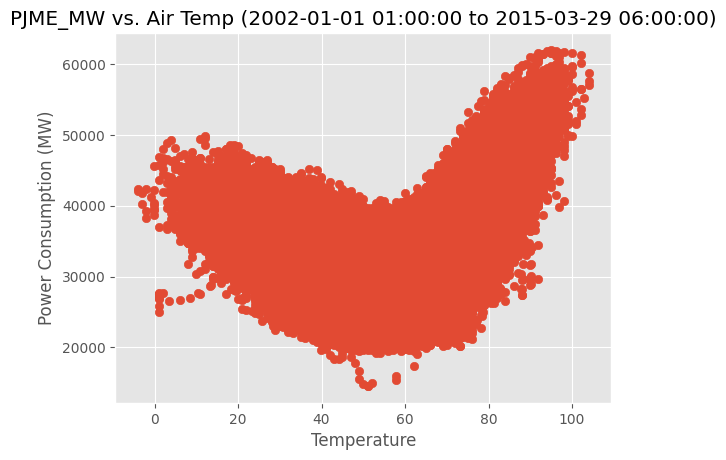

In [ ]:
plt.scatter(train_weather_df["temp_AP"], train_df['PJME_MW'])
train_weather_df["temp_AP"] = train_weather_df.mean(axis=1)

plt.title("PJME_MW vs. Air Temp (2002-01-01 01:00:00 to 2015-03-29 06:00:00)")
plt.xlabel('Temperature')
plt.ylabel('Power Consumption (MW)')
plt.show()

Now to make sure we are using un-polluted values for our LSTM train and test set while preserving the same date range and PJME_MW scaler.

In [ ]:
# this function was made in case it does matter if you apply the scaler seperately

def scale_merge_preserve_split(train_df, test_df):

    df1_length = train_df.shape[0]

    scale_df = pd.concat([train_df, test_df])

    # Normalize the feature(s)
    mw_scaler = MinMaxScaler()
    scale_df['scaled'] = mw_scaler.fit_transform(scale_df[['PJME_MW']].values)

    df1_scaled = scale_df.iloc[:df1_length]
    df2_scaled = scale_df.iloc[df1_length:]

    return([df1_scaled, df2_scaled, mw_scaler])

In [ ]:
LSTM_train = pd.DataFrame(y_train)
LSTM_test =  pd.DataFrame(y_validation)

LSTM_train, LSTM_test, LSTM_w_mw_scaler = scale_merge_preserve_split(LSTM_train, LSTM_test)

In [ ]:
def weather_Scaler(train_weather_df, test_weather_df):

    combined_df = pd.concat([train_weather_df, test_weather_df])

    combined_df['temp'] = combined_df['temp_AP']

    combined_df.drop(labels=['temp_AP'], axis=1, inplace=True)

    weather_scaler = MinMaxScaler()
    combined_df['temp_scaled'] = weather_scaler.fit_transform(combined_df[['temp']])

    return ([combined_df, weather_scaler])

In [ ]:
weather_data, weather_scaler = weather_Scaler(train_weather_df, test_weather_df)

In [ ]:
weather_scaler

MinMaxScaler()

In [ ]:
def combine_MW_weather_scaled(MW_df, Weather_df):

    MW_df['temp_scaled'] = Weather_df.loc[MW_df.index]['temp_scaled'].copy()

    if 'PJME_MW' in MW_df.columns:
        MW_df = MW_df.drop(labels=['PJME_MW'], axis=1)

    return MW_df

In [ ]:
LSTM_w_train = combine_MW_weather_scaled(LSTM_train, weather_data)
LSTM_w_test = combine_MW_weather_scaled(LSTM_test, weather_data)

In [ ]:
def create_multivariate_sequences(train_df, test_df, n_steps_in, n_steps_out):
    # aggregate the data together in chronoglocial order
    combined_data = pd.concat([train_df, test_df])

    # Reshape the dataset suitable for the LSTM model
    input_df = combined_data[['scaled', 'temp_scaled']].values
    output_df = combined_data['scaled'].values.reshape(-1, 1)

    # number of features, 2 in this case (power and temperature)
    n_features = combined_data.shape[1]

    # find total length of data
    total_hours = combined_data.shape[0]

    X = []
    y = []

    for i in range(n_steps_in, total_hours - n_steps_in - n_steps_out + 1):

        X.append(input_df[i - n_steps_in:i])  # Input sequence with both features
        y.append(output_df[i:i + n_steps_out])

    X = np.array(X)
    y = np.array(y)

    # Now, split the data into train and test sets as before
    split_point = len(train_df)

    X_train , X_test = X[:split_point], X[split_point:]
    y_train , y_test = y[:split_point], y[split_point:]

    # Reshape data for LSTM [samples, timesteps, features]
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

    return [X_train, y_train, X_test, y_test]

In [ ]:
n_steps_in, n_steps_out = 24*7, 24*7  # Use previous 7 days in hours to predict the next 7 days in hours

n_features = 2

LSTM_w_train_X, LSTM_w_train_y, LSTM_w_test_X, LSTM_w_test_y = create_multivariate_sequences(LSTM_w_train, LSTM_w_test, n_steps_in, n_steps_out)

In [ ]:
from tensorflow.keras.layers import LSTM, Dense, Dropout

LSTM_w_model = Sequential()
# First LSTM layer with dropout
LSTM_w_model.add(LSTM(50, activation='tanh', return_sequences=True, input_shape=(n_steps_in, n_features)))
LSTM_w_model.add(Dropout(0.2))  # Adding 20% dropout

# Second LSTM layer
LSTM_w_model.add(LSTM(16, activation='tanh'))
LSTM_w_model.add(Dropout(0.2))  # Adding 20% dropout

# Output layer
LSTM_w_model.add(Dense(n_steps_out))

LSTM_w_model.compile(optimizer='adam', loss='mse')

In [ ]:
# Fit the model
history_LSTM_w = LSTM_w_model.fit(
                                  LSTM_w_train_X, LSTM_w_train_y,
                                  epochs=2, # make 20 for final run
                                  batch_size=64,
                                  validation_split=0.1,
                                  verbose=1
)


Epoch 1/2
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 86s 63ms/step - loss: 0.0319 - val_loss: 0.0067
Epoch 2/2
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 83s 64ms/step - loss: 0.0089 - val_loss: 0.0064


In [ ]:
# Predict future values
y_pred_LSTM_w = LSTM_w_model.predict(LSTM_w_test_X)

710/710 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step


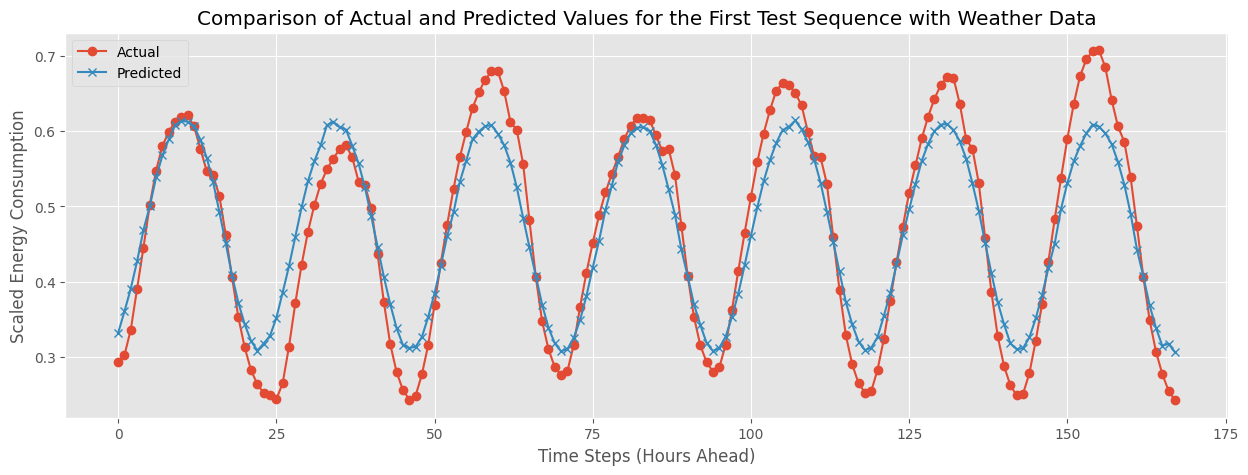

In [ ]:
# Example visualization: Compare the first predicted week to the actual data
plt.figure(figsize=(15, 5))
plt.plot(LSTM_w_test_y[0], label='Actual', marker='o')
plt.plot(y_pred_LSTM_w[0], label='Predicted', marker='x')
plt.title('Comparison of Actual and Predicted Values for the First Test Sequence with Weather Data')
plt.xlabel('Time Steps (Hours Ahead)')
plt.ylabel('Scaled Energy Consumption')
plt.legend()
plt.show()

In [ ]:
# Reshape y_pred and y_test to fit scaler's expected shape
y_pred_LSTM_w_rescaled = LSTM_w_mw_scaler.inverse_transform(y_pred_LSTM_w.reshape(-1, 1))
y_test_LSTM_w_rescaled = LSTM_w_mw_scaler.inverse_transform(LSTM_w_test_y.reshape(-1, 1))

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

mse_LSTM_w = mean_squared_error(y_test_LSTM_w_rescaled, y_pred_LSTM_w_rescaled)
rmse_LSTM_w = np.sqrt(mse_LSTM_w)

r2_LSTM_w = r2_score(y_test_LSTM_w_rescaled, y_pred_LSTM_w_rescaled)

print("Aggregate Mean Squared Error:", mse_LSTM_w)
print("Aggregate Root Mean Squared Error:", rmse_LSTM_w)
print("Aggregate R² Score:", r2_LSTM_w)

Aggregate Mean Squared Error: 16045394.548395898
Aggregate Root Mean Squared Error: 4005.6702995124174
Aggregate R² Score: 0.5694980990391407


In [ ]:
# If y_test was reshaped during preprocessing, reshape it back for metrics calculation
y_pred_LSTM_w_rescaled = y_pred_LSTM_w_rescaled.reshape(y_pred_LSTM_w.shape)
y_test_LSTM_w_rescaled = y_test_LSTM_w_rescaled.reshape(LSTM_w_test_y.shape)

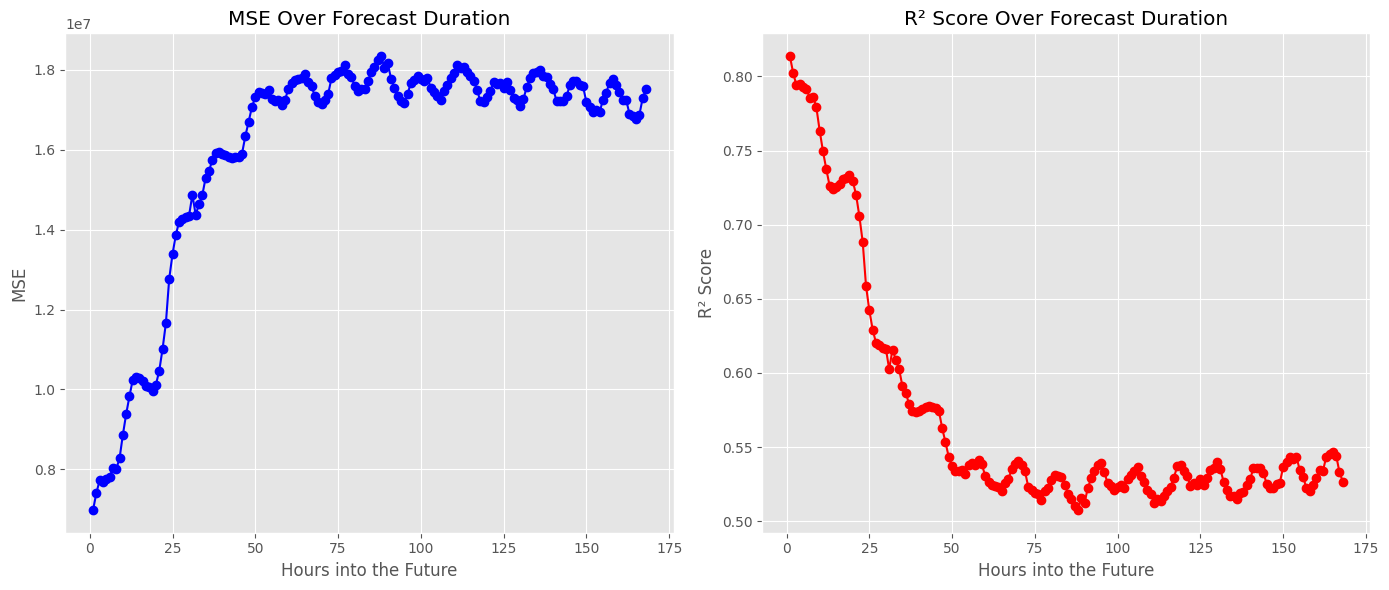

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score


# Calculate MSE and R2 for each forecast hour
mse_LSTM_w_p = [mean_squared_error(y_test_LSTM_w_rescaled[:, i], y_pred_LSTM_w_rescaled[:, i]) for i in range(y_pred_LSTM_w_rescaled.shape[1])]
r2_scores_LSTM_w_p = [r2_score(y_test_LSTM_w_rescaled[:, i], y_pred_LSTM_w_rescaled[:, i]) for i in range(y_pred_LSTM_w_rescaled.shape[1])]

# Plotting the results
hours_LSTM_w_p = np.arange(1, y_pred_LSTM_w_rescaled.shape[1] + 1)
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(hours_LSTM_w_p, mse_LSTM_w_p, marker='o', linestyle='-', color='b')
plt.title('MSE Over Forecast Duration')
plt.xlabel('Hours into the Future')
plt.ylabel('MSE')

plt.subplot(1, 2, 2)
plt.plot(hours_LSTM_w_p, r2_scores_LSTM_w_p, marker='o', linestyle='-', color='r')
plt.title('R² Score Over Forecast Duration')
plt.xlabel('Hours into the Future')
plt.ylabel('R² Score')

plt.tight_layout()
plt.show()

# Model #4 - XGBoost
* How model works:
* Performance metrics of model:
  * Aggregate Mean Squared Error: 12973694.776688829
  * Aggregate Root Mean Squared Error: 3601.9015501105564
  * Aggregate R² Score: 0.6911604195827705

In [ ]:
X_train = X_train_l[3]
y_train = y_train_l[3]
X_validation = X_validation_l[3]
y_validation = y_validation_l[3]

XGB_train = pd.DataFrame(y_train)
XGB_test =  pd.DataFrame(y_validation)

In [ ]:
# this function was made in case it does matter if you apply the scaler seperately

def scale_merge_preserve_split(train_df, test_df):

    df1_length = train_df.shape[0]

    scale_df = pd.concat([train_df, test_df])

    # Normalize the feature(s)
    mw_scaler = MinMaxScaler()
    scale_df['scaled'] = mw_scaler.fit_transform(scale_df[['PJME_MW']].values)

    df1_scaled = scale_df.iloc[:df1_length]
    df2_scaled = scale_df.iloc[df1_length:]

    return([df1_scaled, df2_scaled, mw_scaler])

In [ ]:
XGB_train, XGB_test, XGB_mw_scaler = scale_merge_preserve_split(XGB_train, XGB_test)

In [ ]:
XGB_mw_scaler

MinMaxScaler()

In [ ]:
def create_sequences_XGB(train_df, test_df, n_steps_in, n_steps_out):

    X = []
    y = []

    # aggregate the data together in chronoglocial order
    sequence_df = pd.concat([train_df, test_df])

    # Reshape the dataset suitable for the LSTM model
    sequence_df = sequence_df['scaled'].values.reshape(-1, 1)

    # find total number of hours in data
    total_hours = sequence_df.shape[0]

    for i in range(total_hours - n_steps_in - n_steps_out + 1):

        X.append(sequence_df[i:(i + n_steps_in), 0])
        y.append(sequence_df[(i + n_steps_in):(i + n_steps_in + n_steps_out), 0])

    X = np.array(X)
    y = np.array(y)

    # Split data back into train and test sets
    split_point = len(train_df)

    X_train, X_test = X[:split_point], X[split_point:]
    y_train, y_test = y[:split_point], y[split_point:]


    return [X_train, y_train, X_test, y_test]

In [ ]:
# Example settings
n_steps_in, n_steps_out = 24*7, 24*7  # Use previous 7 days in hours to predict the next 7 days in hours

XGB_train_X, XGB_train_y, XGB_test_X, XGB_test_y = create_sequences_XGB(XGB_train, XGB_test, n_steps_in, n_steps_out)

In [ ]:
XGB_train_y_flat = XGB_train_y.reshape(-1, 1)
XGB_test_y_flat = XGB_test_y.reshape(-1, 1)

Train the data only on the train set, but show its performance on the validation set.

In [ ]:
import xgboost as xgb

XGB_reg1 = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, early_stopping_rounds=10, learning_rate=0.01, max_depth=3)
XGB_reg1.fit(XGB_train_X, XGB_train_y_flat,
             eval_set = [(XGB_train_X, XGB_train_y_flat), (XGB_test_X, XGB_test_y_flat)],
             eval_metric='rmse',
             verbose=1)

[0]	validation_0-rmse:0.13641	validation_1-rmse:0.12847
[1]	validation_0-rmse:0.13551	validation_1-rmse:0.12765
[2]	validation_0-rmse:0.13463	validation_1-rmse:0.12684
[3]	validation_0-rmse:0.13375	validation_1-rmse:0.12604
[4]	validation_0-rmse:0.13289	validation_1-rmse:0.12524
[5]	validation_0-rmse:0.13204	validation_1-rmse:0.12446
[6]	validation_0-rmse:0.13120	validation_1-rmse:0.12369
[7]	validation_0-rmse:0.13037	validation_1-rmse:0.12293
[8]	validation_0-rmse:0.12955	validation_1-rmse:0.12219
[9]	validation_0-rmse:0.12874	validation_1-rmse:0.12145
[10]	validation_0-rmse:0.12795	validation_1-rmse:0.12072
[11]	validation_0-rmse:0.12716	validation_1-rmse:0.12000
[12]	validation_0-rmse:0.12638	validation_1-rmse:0.11930
[13]	validation_0-rmse:0.12562	validation_1-rmse:0.11860
[14]	validation_0-rmse:0.12486	validation_1-rmse:0.11791
[15]	validation_0-rmse:0.12411	validation_1-rmse:0.11723
[16]	validation_0-rmse:0.12338	validation_1-rmse:0.11656
[17]	validation_0-rmse:0.12265	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred_XGB_reg1 = XGB_reg1.predict(XGB_test_X)

In [ ]:
y_pred_XGB_reg1_rescaled = XGB_mw_scaler.inverse_transform(y_pred_XGB_reg1.reshape(-1, 1))
y_test_XGB_reg1_rescaled = XGB_mw_scaler.inverse_transform(XGB_test_y_flat)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Compute the Mean Squared Error
mse_XGB_reg1 = mean_squared_error(y_test_XGB_reg1_rescaled, y_pred_XGB_reg1_rescaled)

# Compute the Root Mean Squared Error
rmse_XGB_reg1 = np.sqrt(mse_XGB_reg1)

# Compute the R² Score
r2_XGB_reg1 = r2_score(y_test_XGB_reg1_rescaled, y_pred_XGB_reg1_rescaled)

print("Aggregate Mean Squared Error:", mse_XGB_reg1)
print("Aggregate Root Mean Squared Error:", rmse_XGB_reg1)
print("Aggregate R² Score:", r2_XGB_reg1)

Aggregate Mean Squared Error: 16198211.91158836
Aggregate Root Mean Squared Error: 4024.700226301129
Aggregate R² Score: 0.5631955637395369


In [ ]:
y_pred_XGB_reg1_rescaled = y_pred_XGB_reg1_rescaled.reshape(XGB_test_y.shape)
y_test_XGB_reg1_rescaled = y_test_XGB_reg1_rescaled.reshape(XGB_test_y.shape)

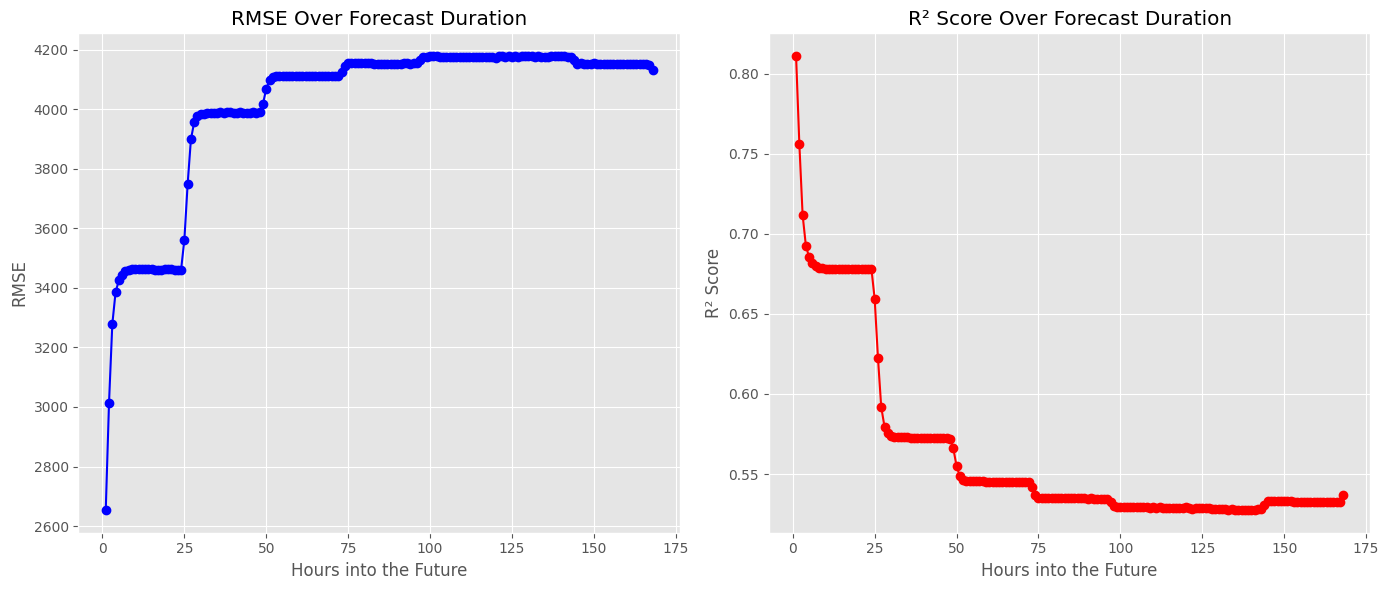

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# enter re-scaled data to return forecast
# y_test_XGB_reg1_rescaled, y_pred_XGB_reg1_rescaled

def plot_RMSE_R2(y_test_rescaled, y_pred_rescaled):

    # Calculate RMSE and R2 for each forecast hour
    rmse_scores_XGB_reg1 = [np.sqrt(mean_squared_error(y_test_rescaled[:, i],
                                              y_pred_rescaled[:, i])) for i in range(y_pred_rescaled.shape[1])]

    r2_scores_XGB_reg1 = [r2_score(y_test_rescaled[:, i], y_pred_rescaled[:, i]) for i in range(y_pred_rescaled.shape[1])]

    # Plotting the results
    hours_XGB_reg1 = np.arange(1, y_pred_rescaled.shape[1] + 1)
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(hours_XGB_reg1, rmse_scores_XGB_reg1, marker='o', linestyle='-', color='b')
    plt.title('RMSE Over Forecast Duration')
    plt.xlabel('Hours into the Future')
    plt.ylabel('RMSE')

    plt.subplot(1, 2, 2)
    plt.plot(hours_XGB_reg1, r2_scores_XGB_reg1, marker='o', linestyle='-', color='r')
    plt.title('R² Score Over Forecast Duration')
    plt.xlabel('Hours into the Future')
    plt.ylabel('R² Score')

    plt.tight_layout()
    plt.show()

    return

plot_RMSE_R2(y_test_XGB_reg1_rescaled, y_pred_XGB_reg1_rescaled)

# Investigation of XGBoost Regression For Feature Importance

https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/

Here I will use XGBoost on the base data in order to determine what features our final XGBoost model will be using in its decision trees.

I will also scale the data with the min-max scaler as we have exited the EDA stage and are entering the feature selection / model building stage.

I will use this information to keep, what features to expand on, and see if the cross validation makes a difference as to determining how to value feature importance as a method of feature selection.

### Cardinality

One thing to keep in mind as well is the Cardinality of the features when dealing with XGBoost or any decision tree algorithm. It might be the case that certain variables are simply better at more finely partitioning the dataset than others, which means that they might rank higher on feature importance by chance rather than because of a good reason.


dayofyear : range of 1 to 366

weekofyear : range of 1 to 53

day (of month) : range of 1 to 31

hour : range of 0 to 23

year : range of 2002 to 2015

month : range of 1 to 12

dayofweek : range of 0 to 6

quarter: range of 0 to 4

So I have to be concious of the fact that dayofyear particalularly has a high ability to partition the datatset compared to the other variables.

### Data Scaling with MinMaxScaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaled_pjme_fi = train_df.copy()

# this scaler object will remember the transformation, can fit to represent in original value scale
scaler = MinMaxScaler()
scaled_pjme_fi['PJME_MW'] = scaler.fit_transform(train_df[['PJME_MW']].values)
scaled_pjme_fi.rename(columns={'PJME_MW' : 'scaled_PJME_MW'}, inplace=True)
scaled_pjme_fi = create_features(scaled_pjme_fi)

scaled_pjme_fi.head()

,scaled_PJME_MW,hour,day,dayofweek,Dayofyear,weekofyear,month,year,Quarter
2002-01-01 01:00:00,0.333909,1,1,1,1,1,1,2002,1
2002-01-01 02:00:00,0.310144,2,1,1,1,1,1,2002,1
2002-01-01 03:00:00,0.291014,3,1,1,1,1,1,2002,1
2002-01-01 04:00:00,0.281365,4,1,1,1,1,1,2002,1
2002-01-01 05:00:00,0.284694,5,1,1,1,1,1,2002,1


In [ ]:
scaled_pjme_fi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 116046 entries, 2002-01-01 01:00:00 to 2015-03-29 06:00:00
Freq: H
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   scaled_PJME_MW  116046 non-null  float64
 1   hour            116046 non-null  int32  
 2   day             116046 non-null  int32  
 3   dayofweek       116046 non-null  int32  
 4   Dayofyear       116046 non-null  int32  
 5   weekofyear      116046 non-null  int32  
 6   month           116046 non-null  int32  
 7   year            116046 non-null  int32  
 8   Quarter         116046 non-null  int32  
dtypes: float64(1), int32(8)
memory usage: 5.3 MB


In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [ ]:
def run_XGB_reg(df, my_folds=4, my_n_estimators=10000, my_learning_rate=0.001, my_max_depth=3, my_early_stopping_rounds=100, verbose=1000, seed=0):
    results = []
    #my_n_estimators = 10000
    #my_learning_rate = 0.001
    #my_early_stopping_rounds = 100

    X_train_l, y_train_l, X_validation_l, y_validation_l = k_fold_cv_ts(df, n_splits=my_folds)

    for i in range(my_folds):
        reg = xgb.XGBRegressor(n_estimators= my_n_estimators,
                               early_stopping_rounds= my_early_stopping_rounds,
                               max_depth= my_max_depth,
                               learning_rate= my_learning_rate,
                               seed = seed)

        print(f'Fold {i  + 1}')

        reg.fit(X_train_l[i], y_train_l[i],
                eval_set = [(X_train_l[i], y_train_l[i]), (X_validation_l[i], y_validation_l[i])],
                verbose= verbose)

        results.append(reg)

    return results

In [ ]:
XGB_fi_results = run_XGB_reg(scaled_pjme_fi,
                             my_folds=4,
                             my_n_estimators=10000,
                             my_learning_rate=0.001,
                             my_early_stopping_rounds=100,
                             verbose=1000,
                             seed=0)

Fold 1
[0]	validation_0-rmse:0.13351	validation_1-rmse:0.13677
[1000]	validation_0-rmse:0.09341	validation_1-rmse:0.10162
[2000]	validation_0-rmse:0.07821	validation_1-rmse:0.08848
[3000]	validation_0-rmse:0.06980	validation_1-rmse:0.08094
[4000]	validation_0-rmse:0.06499	validation_1-rmse:0.07763
[5000]	validation_0-rmse:0.06224	validation_1-rmse:0.07566
[6000]	validation_0-rmse:0.06022	validation_1-rmse:0.07497
[7000]	validation_0-rmse:0.05861	validation_1-rmse:0.07451
[7172]	validation_0-rmse:0.05835	validation_1-rmse:0.07453
Fold 2
[0]	validation_0-rmse:0.13495	validation_1-rmse:0.13524
[1000]	validation_0-rmse:0.09642	validation_1-rmse:0.09571
[2000]	validation_0-rmse:0.08116	validation_1-rmse:0.08114
[3000]	validation_0-rmse:0.07250	validation_1-rmse:0.07431
[4000]	validation_0-rmse:0.06748	validation_1-rmse:0.07180
[5000]	validation_0-rmse:0.06416	validation_1-rmse:0.07089
[5523]	validation_0-rmse:0.06303	validation_1-rmse:0.07080
Fold 3
[0]	validation_0-rmse:0.13502	validation_

In [ ]:
def display_XGB_fi_results(results, vals=True, display=True):

    fi_reg_list = []

    for result in results:
        fi_reg = pd.DataFrame(data=result.feature_importances_,
                 index=result.feature_names_in_,
                 columns=['importance'])

        fi_reg = fi_reg.sort_values('importance')

        fi_reg_list.append(fi_reg)

        if display:

            fi_reg.plot(kind='barh', figsize=(2, 2),title='Feature Importance').legend(loc='right')

            plt.show()

    if vals:
        return fi_reg_list

    return

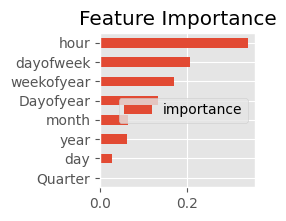

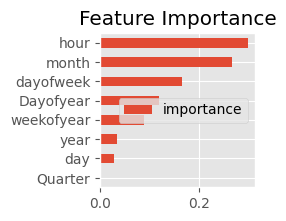

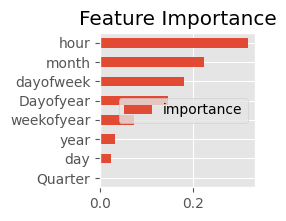

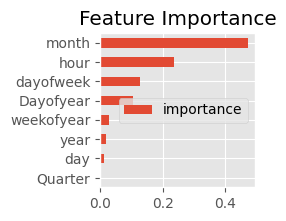

In [ ]:
display_XGB_fi_results(XGB_fi_results, vals=False, display=True)

So the most important features according the the XGBoost regression on the scaled features are the hour, month, week, dayofweek, and dayofyear. Some of these variables are most likely highly correlated to each other, so we have to keep this in mind when chosing our features to keep for the model.

Here is a list of variables that I believe are correlated to each other:

month: week of year

As we saw in the plots in the EDA, month and week of year model very similar behavior. Week of year gives a more segmented distinction from month, but despite this, month seems to maintain importance over the week of year in our feature importance graphs.

month: quarter

This is sort of the reverse situation from month and week; quarter is a lower resolution / less segmentation variable than month. Given that it has no feature relevance on any of the folds, I think it should be dropped from future models.


dayofyear: year

weekofyear: year

These are relatively self explanatory; the values are both ways of segmenting a year.

I will make some basic choices here:

I will drop quarter, day of month, and year. If the model performs better over the validation sets, I will move on to trying to forecast with these variables.

In [ ]:
XGB_fi_results2 = run_XGB_reg(scaled_pjme_fi.drop(columns=['Quarter', 'day', 'year'], axis=1),
                              my_folds=4,
                              my_n_estimators=10000,
                              my_learning_rate=0.001,
                              my_early_stopping_rounds=100,
                              verbose=1000,
                              seed=0)

Fold 1
[0]	validation_0-rmse:0.13351	validation_1-rmse:0.13677
[1000]	validation_0-rmse:0.09350	validation_1-rmse:0.10146
[2000]	validation_0-rmse:0.07858	validation_1-rmse:0.08842
[3000]	validation_0-rmse:0.07076	validation_1-rmse:0.08078
[4000]	validation_0-rmse:0.06670	validation_1-rmse:0.07698
[5000]	validation_0-rmse:0.06472	validation_1-rmse:0.07526
[6000]	validation_0-rmse:0.06338	validation_1-rmse:0.07414
[7000]	validation_0-rmse:0.06240	validation_1-rmse:0.07344
[8000]	validation_0-rmse:0.06166	validation_1-rmse:0.07286
[9000]	validation_0-rmse:0.06091	validation_1-rmse:0.07242
[9999]	validation_0-rmse:0.06029	validation_1-rmse:0.07201
Fold 2
[0]	validation_0-rmse:0.13495	validation_1-rmse:0.13524
[1000]	validation_0-rmse:0.09642	validation_1-rmse:0.09568
[2000]	validation_0-rmse:0.08128	validation_1-rmse:0.08110
[3000]	validation_0-rmse:0.07295	validation_1-rmse:0.07430
[4000]	validation_0-rmse:0.06878	validation_1-rmse:0.07135
[5000]	validation_0-rmse:0.06656	validation_1-rm

In [ ]:
# this function takes the difference between the first input of feature importances and the second input of feature importances

def difference_in_fi(results1, results2):

    row_idx = list(set(results1[0].index.to_list()) & set(results2[0].index.to_list()))

    difference = []

    for i in range(len(results1)):

        difference.append((results1[i]['importance'][row_idx] - results2[i]['importance'][row_idx]).sort_values(ascending=False))

    return difference

In [ ]:
difference_in_fi(display_XGB_fi_results(XGB_fi_results2, vals=True, display=False), display_XGB_fi_results(XGB_fi_results, vals=True, display=False))

[month         0.045970
 hour          0.030834
 dayofweek     0.021260
 Dayofyear     0.017612
 weekofyear   -0.026918
 Name: importance, dtype: float32,
 month         0.135245
 Dayofyear    -0.000785
 dayofweek    -0.010487
 weekofyear   -0.022334
 hour         -0.038438
 Name: importance, dtype: float32,
 month         0.079855
 hour          0.003883
 Dayofyear    -0.003350
 weekofyear   -0.009061
 dayofweek    -0.014850
 Name: importance, dtype: float32,
 month         0.021076
 Dayofyear     0.021051
 weekofyear   -0.000349
 dayofweek    -0.003015
 hour         -0.007895
 Name: importance, dtype: float32]

Now, I will try something different. Because I established above that I think month is the variable that is the most highly correlated with other variables in the model, and because it has the highest feature importance across the majority of models, I want to see what happens if I remove it, and which variables will have increased/decreased feature importances as a result.

In [ ]:
XGB_fi_results3 = run_XGB_reg(scaled_pjme_fi.loc[:, scaled_pjme_fi.columns != 'month'],
                              my_folds=4,
                              my_n_estimators=10000,
                              my_learning_rate=0.001,
                              my_early_stopping_rounds=100,
                              verbose=1000,
                              seed=0)

Fold 1
[0]	validation_0-rmse:0.13351	validation_1-rmse:0.13677
[1000]	validation_0-rmse:0.09341	validation_1-rmse:0.10162
[2000]	validation_0-rmse:0.07822	validation_1-rmse:0.08848
[3000]	validation_0-rmse:0.06984	validation_1-rmse:0.08087
[4000]	validation_0-rmse:0.06501	validation_1-rmse:0.07767
[5000]	validation_0-rmse:0.06225	validation_1-rmse:0.07581
[6000]	validation_0-rmse:0.06023	validation_1-rmse:0.07507
[7000]	validation_0-rmse:0.05855	validation_1-rmse:0.07468
[7050]	validation_0-rmse:0.05847	validation_1-rmse:0.07469
Fold 2
[0]	validation_0-rmse:0.13495	validation_1-rmse:0.13524
[1000]	validation_0-rmse:0.09645	validation_1-rmse:0.09573
[2000]	validation_0-rmse:0.08119	validation_1-rmse:0.08114
[3000]	validation_0-rmse:0.07253	validation_1-rmse:0.07431
[4000]	validation_0-rmse:0.06752	validation_1-rmse:0.07181
[5000]	validation_0-rmse:0.06422	validation_1-rmse:0.07087
[5812]	validation_0-rmse:0.06252	validation_1-rmse:0.07075
Fold 3
[0]	validation_0-rmse:0.13502	validation_

In [ ]:
def model_scores(XGB_res):
    XGB_scores_val_0 = []
    XGB_scores_val_1 = []

    for i in range(len(XGB_res)):
        XGB_scores_val_0.append(XGB_res[i].evals_result()['validation_0']['rmse'][-1])
        XGB_scores_val_1.append(XGB_res[i].evals_result()['validation_1']['rmse'][-1])

    end_scores_df = pd.DataFrame({'fold': [1, 2, 3, 4]})

    end_scores_df['train_score'] = XGB_scores_val_0
    end_scores_df['validation_score'] = XGB_scores_val_1
    end_scores_df['difference'] = end_scores_df['train_score'] - end_scores_df['validation_score']

    return end_scores_df

above is updated version, delete this if no problems


def model_scores(XGB_res):
    XGB_scores_val_0 = []
    XGB_scores_val_1 = []
    
    for i in range(len(XGB_df_fi_results)):
        XGB_scores_val_0.append(XGB_res[i].evals_result()['validation_0']['rmse'][-1])
        XGB_scores_val_1.append(XGB_res[i].evals_result()['validation_1']['rmse'][-1])

    end_scores_df = pd.DataFrame({'fold': [1, 2, 3, 4]})
    
    end_scores_df['train_score'] = XGB_scores_val_0
    end_scores_df['validation_score'] = XGB_scores_val_1
    end_scores_df['difference'] = end_scores_df['train_score'] - end_scores_df['validation_score']

    return end_scores_df

In [ ]:
model_scores(XGB_fi_results)

,fold,train_score,validation_score,difference
0,1,0.058342,0.074534,-0.016192
1,2,0.063027,0.070796,-0.007769
2,3,0.063203,0.078029,-0.014826
3,4,0.069336,0.077751,-0.008415


In [ ]:
abs(sum(model_scores(XGB_fi_results)['difference']))

0.0472020981953437

In [ ]:
model_scores(XGB_fi_results2)

,fold,train_score,validation_score,difference
0,1,0.060294,0.072014,-0.011720
1,2,0.062588,0.068234,-0.005647
2,3,0.064072,0.073278,-0.009206
3,4,0.065537,0.075427,-0.009890


In [ ]:
abs(sum(model_scores(XGB_fi_results2)['difference']))

0.036463587609887174

In [ ]:
model_scores(XGB_fi_results3)

,fold,train_score,validation_score,difference
0,1,0.058472,0.074685,-0.016214
1,2,0.062517,0.070750,-0.008233
2,3,0.063124,0.078003,-0.014879
3,4,0.069336,0.077780,-0.008444


In [ ]:
abs(sum(model_scores(XGB_fi_results3)['difference']))

0.04776954979232835

I noticed a difference in the rmse between different XGB feature importance models. In the model where I left out 'Quarter', 'day', 'year' variables, it seemed on average generalize better to the validation set. You can see it by the fact that the sum of the differences between the train and validation scores for each respective feature importance regressor is the smallest for the model where I dropped the trio of aforementioned variables.

Throughout the folds, there is a tendency for the model that dropped 'Quarter', 'day', 'year' variables to generalize better to the validation set. To me, this indicates that removing these unecessary variables reduces overfitting, so I will remove them when chosing to attempt to optimize a final model.

In [ ]:
display_XGB_fi_results(XGB_fi_results3, vals=True, display=False)

[            importance
 Quarter       0.000000
 day           0.029203
 year          0.065112
 Dayofyear     0.139410
 weekofyear    0.184257
 dayofweek     0.219450
 hour          0.362568,
             importance
 Quarter       0.000000
 day           0.034497
 year          0.045925
 weekofyear    0.117899
 Dayofyear     0.184265
 dayofweek     0.222025
 hour          0.395389,
             importance
 Quarter       0.000000
 day           0.030428
 year          0.041137
 weekofyear    0.094028
 Dayofyear     0.197796
 dayofweek     0.229542
 hour          0.407070,
             importance
 day           0.022679
 year          0.028930
 weekofyear    0.046223
 Quarter       0.086798
 Dayofyear     0.204034
 dayofweek     0.214980
 hour          0.396356]

In [ ]:
difference_in_fi(display_XGB_fi_results(XGB_fi_results3, vals=True, display=False), display_XGB_fi_results(XGB_fi_results, vals=True, display=False))

[hour          0.023748
 weekofyear    0.015113
 dayofweek     0.013108
 Dayofyear     0.006475
 year          0.004060
 day           0.001498
 Quarter       0.000000
 Name: importance, dtype: float32,
 hour          0.097456
 Dayofyear     0.065518
 dayofweek     0.056413
 weekofyear    0.029704
 year          0.011115
 day           0.006107
 Quarter       0.000000
 Name: importance, dtype: float32,
 hour          0.088359
 Dayofyear     0.050959
 dayofweek     0.048924
 weekofyear    0.020680
 year          0.008800
 day           0.006289
 Quarter       0.000000
 Name: importance, dtype: float32,
 hour          0.159611
 Dayofyear     0.099698
 Quarter       0.086798
 dayofweek     0.086572
 weekofyear    0.018706
 year          0.011612
 day           0.009129
 Name: importance, dtype: float32]

Above, you can see the features that gained the most importance in decending order. Hour gained the most feature importance after dropping month, but that is to be expected as it was the top variable prior, and without month information, the model decides to default to using hour more to partition the dataset. I think what is most interesting is that weekofyear doesn't really gain much, which means that it may be more seperate than months than previously assumed despite the obvious relationship between the two (both being segmentations of year).

# XGBoost with Engineered Features

## Potential Types of features to include in decision tree and XGBoost model

1. Time-based features
2. Lagged Features
3. Rolling Window Statistics based on PJME_MW values
4. Weather Data

We already added time-based features in the form of values such as hour/day/week/month etc. I will add other variables such as checking for a holiday, and potentially convert variables like dayofweek to a check of if a date is on a weekend or weekday.

I will use information built up based on all of our previous data analysis to do feature engineering, and then try to optimize the model. First I will drop the variables detailed above: 'Quarter', 'day', 'year'

## 1., 2., 3., 4. Adding More Advanced Features

In [ ]:
def add_features(input_df):

    final_XGB = create_features(input_df)

    if 'PJME_MW' in final_XGB.columns:

        mw_scaler = MinMaxScaler()
        final_XGB['PJME_MW'] = mw_scaler.fit_transform(final_XGB[['PJME_MW']].values)
        final_XGB.rename(columns={'PJME_MW':'scaled_PJME_MW'},inplace=True)

    final_XGB.drop(columns=['Quarter', 'day', 'year'], inplace=True)

    dr = final_XGB.index
    df = pd.DataFrame()
    df['date'] = dr

    # return df
    cal = calendar()
    holidays = cal.holidays(start=dr.min(), end=dr.max())

    #return holidays
    df['Holiday'] = df['date'].dt.date.astype('datetime64[ns]').isin(holidays)

    df['Holiday'] = df['Holiday'].replace({True: 1, False: 0})

    final_XGB['holiday'] = list(df['Holiday'].values)

    final_XGB['dayofweek'] = final_XGB['dayofweek'].replace({0 : 0, 1 : 0, 2 : 0, 3 : 0, 4 : 0, 5 : 1, 6 : 1})

    if 'weekend' in final_XGB.columns:
        final_XGB.drop(columns=['weekend'], inplace=True)

    final_XGB.rename(columns={'dayofweek' : 'weekend'}, inplace=True)


    # # I will drop day of the year because I think it has a high ability to partition the dataset but
    # doesn't really add represention of information that we already have access to (seasonality) and it has high cardinality.
    final_XGB.drop(labels={'Dayofyear'}, axis=1, inplace=True)

    # 1 week in hours is 7 days * 24 hours, or 168. To use 2 weeks worth of data, we can use a lag of 168 * 2 = 336 hours.

    target_map1 = final_XGB['scaled_PJME_MW'].to_dict()

    final_XGB['lag_1_week'] = (final_XGB.index - pd.Timedelta('168 hours')).map(target_map1)
    final_XGB['lag_2_week'] = (final_XGB.index - pd.Timedelta('336 hours')).map(target_map1)

    final_XGB['RollingMean'] = final_XGB['scaled_PJME_MW'].rolling(pd.Timedelta('336 hours')).mean()
    final_XGB['RollingMedian'] = final_XGB['scaled_PJME_MW'].rolling(pd.Timedelta('336 hours')).median()

    target_map2 = final_XGB['RollingMean'].to_dict()
    target_map3 = final_XGB['RollingMedian'].to_dict()

    final_XGB['lag_RollingMean'] = (final_XGB.index - pd.Timedelta('168 hours')).map(target_map2)
    final_XGB['lag_RollingMedian'] = (final_XGB.index - pd.Timedelta('168 hours')).map(target_map3)

    final_XGB['temp_scaled'] = weather_data['temp_scaled']

    target_map4 = final_XGB['temp_scaled'].to_dict()

    final_XGB['lag_temp_scaled'] = (final_XGB.index - pd.Timedelta('168 hours')).map(target_map4)

    # dropping these because we won't have access to them in our prediction window.
    final_XGB.drop(labels=['RollingMean', 'RollingMedian', 'temp_scaled'], axis=1, inplace=True)

    return final_XGB

In [ ]:
XGB_train_df = add_features(train_df)
XGB_train_df

,scaled_PJME_MW,hour,weekend,weekofyear,month,holiday,lag_1_week,lag_2_week,lag_RollingMean,lag_RollingMedian,lag_temp_scaled
2002-01-01 01:00:00,0.333909,1,0,1,1,0,NaN,NaN,NaN,NaN,NaN
2002-01-01 02:00:00,0.310144,2,0,1,1,0,NaN,NaN,NaN,NaN,NaN
2002-01-01 03:00:00,0.291014,3,0,1,1,0,NaN,NaN,NaN,NaN,NaN
2002-01-01 04:00:00,0.281365,4,0,1,1,0,NaN,NaN,NaN,NaN,NaN
2002-01-01 05:00:00,0.284694,5,0,1,1,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2015-03-29 02:00:00,0.310545,2,1,13,3,0,0.217192,0.205436,0.338477,0.337375,0.453333
2015-03-29 03:00:00,0.304414,3,1,13,3,0,0.210387,0.197345,0.338228,0.337375,0.453333
2015-03-29 04:00:00,0.302834,4,1,13,3,0,0.209038,0.193743,0.337983,0.337375,0.463333
2015-03-29 05:00:00,0.309238,5,1,13,3,0,0.215359,0.197029,0.337756,0.337375,0.463333


As you can see, 2015-03-15 06:00:00	scaled_PJME_MW values is equal to 2015-03-29 06:00:00 lag_two_weeks value; 0.210597.


## 3. Rolling Window Statistics

Rolling Mean: Moving average over a time period.

Rolling Median: Meadian over a time period.

I think that one of the hardest parts to measure are the points that were underepresented in models like prohpet, where the model can't necessarily account for the degree of some of the higher power supply data. To that end, I wil add the two rolling statistics from above to the data.

## Rolling Mean; 2 weeks aggregation, 2 weeks lag

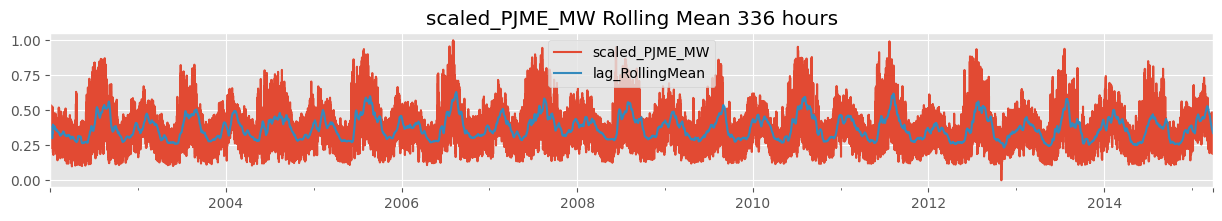

In [ ]:
fig, ax = plt.subplots(figsize=(15, 2))

# two week rolling mean
XGB_train_df['scaled_PJME_MW'].plot(ax=ax, label='scaled_PJME_MW', title='scaled_PJME_MW Rolling Mean 336 hours')
XGB_train_df['lag_RollingMean'].plot(ax=ax, label='Rolling Mean')

ax.legend(['scaled_PJME_MW', 'lag_RollingMean'])
plt.show()

## Rolling Median, 2 weeks, 2 weeks lag

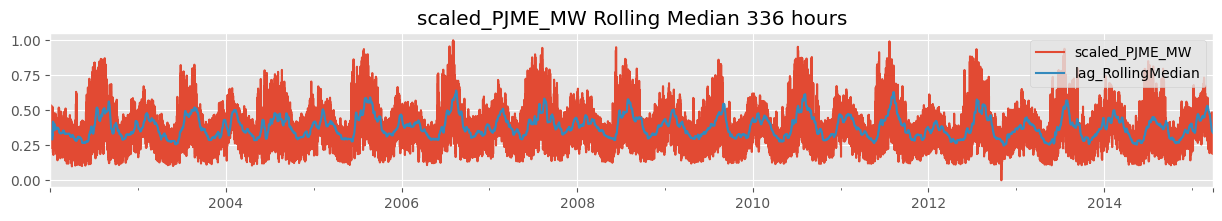

In [ ]:
fig, ax = plt.subplots(figsize=(15, 2))

# two week rolling mean
XGB_train_df['scaled_PJME_MW'].plot(ax=ax, label='scaled_PJME_MW', title='scaled_PJME_MW Rolling Median 336 hours')
XGB_train_df['lag_RollingMedian'].plot(ax=ax, label='Rolling Median')

ax.legend(['scaled_PJME_MW', 'lag_RollingMedian'])
plt.show()

# Final XGBoost Model Building, Grid Search

I will now build the final XGBoost Model, and utilize grid search to try to achieve the best result on the validation set. Then, I will predict on the test set.

In [ ]:
XGB_train_df

,scaled_PJME_MW,hour,weekend,weekofyear,month,holiday,lag_1_week,lag_2_week,lag_RollingMean,lag_RollingMedian,lag_temp_scaled
2002-01-01 01:00:00,0.333909,1,0,1,1,0,NaN,NaN,NaN,NaN,NaN
2002-01-01 02:00:00,0.310144,2,0,1,1,0,NaN,NaN,NaN,NaN,NaN
2002-01-01 03:00:00,0.291014,3,0,1,1,0,NaN,NaN,NaN,NaN,NaN
2002-01-01 04:00:00,0.281365,4,0,1,1,0,NaN,NaN,NaN,NaN,NaN
2002-01-01 05:00:00,0.284694,5,0,1,1,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2015-03-29 02:00:00,0.310545,2,1,13,3,0,0.217192,0.205436,0.338477,0.337375,0.453333
2015-03-29 03:00:00,0.304414,3,1,13,3,0,0.210387,0.197345,0.338228,0.337375,0.453333
2015-03-29 04:00:00,0.302834,4,1,13,3,0,0.209038,0.193743,0.337983,0.337375,0.463333
2015-03-29 05:00:00,0.309238,5,1,13,3,0,0.215359,0.197029,0.337756,0.337375,0.463333


In [ ]:
from sklearn.model_selection import GridSearchCV

def Grid_Search_with_K_fold_validation(df, param_grid, scoring, my_folds=4, my_early_stopping_rounds=100, verbose=1000, seed=0):

    X_train_l, y_train_l, X_validation_l, y_validation_l = k_fold_cv_ts(df, n_splits=my_folds)

    results_per_fold = []

    # Define the model
    model = xgb.XGBRegressor(objective='reg:squarederror', early_stopping_rounds=my_early_stopping_rounds, seed=seed)

    # Define the grid of hyperparameters to search
    param_grid = param_grid



    cv=[(slice(None), slice(None))]

    # Setup the grid search
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv, # Number of cross-validation folds (k-fold), I will be doing that seperately through data inputs so I want no cross validation here
        scoring=scoring,
        verbose=verbose
    )

    for i in range(my_folds):
        if i != 1:
            print('')

        print('###########################################################################################################################')
        print(f'Fold [{i}]')
        print('')

        grid_search.fit(X_train_l[i], y_train_l[i],
                        eval_set=[(X_validation_l[i], y_validation_l[i])],
                        verbose=verbose)

        results_per_fold.append(pd.DataFrame(grid_search.cv_results_))

    return results_per_fold

In [ ]:
param_grid = {'n_estimators': [500, 1000, 1500],
              'max_depth': [3, 4, 5, 6],
              'learning_rate' : [0.01],
              }

Grid_search_results = Grid_Search_with_K_fold_validation(XGB_train_df,
                                                         param_grid,
                                                         scoring='neg_mean_squared_error',
                                                         my_folds=4,
                                                         my_early_stopping_rounds=1000,
                                                         verbose=100,
                                                         seed=0)


###########################################################################################################################
Fold [0]

Fitting 1 folds for each of 12 candidates, totalling 12 fits
[CV 1/1; 1/12] START learning_rate=0.01, max_depth=3, n_estimators=500..........
[0]	validation_0-rmse:0.13600
[100]	validation_0-rmse:0.09107
[200]	validation_0-rmse:0.08021
[300]	validation_0-rmse:0.07787
[400]	validation_0-rmse:0.07599
[499]	validation_0-rmse:0.07601
[CV 1/1; 1/12] END learning_rate=0.01, max_depth=3, n_estimators=500;, score=-0.004 total time=   1.5s
[CV 1/1; 2/12] START learning_rate=0.01, max_depth=3, n_estimators=1000.........
[0]	validation_0-rmse:0.13600
[100]	validation_0-rmse:0.09107
[200]	validation_0-rmse:0.08021
[300]	validation_0-rmse:0.07787
[400]	validation_0-rmse:0.07599
[500]	validation_0-rmse:0.07600
[600]	validation_0-rmse:0.07601
[700]	validation_0-rmse:0.07623
[800]	validation_0-rmse:0.07658
[900]	validation_0-rmse:0.07688
[999]	validation_0-rmse:0.07697

In [ ]:
len(Grid_search_results)

4

In [ ]:
Grid_search_results[0]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,1.510931,0.0,0.049867,0.0,0.01,3,500,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",-0.004080,-0.004080,0.0,12
1,2.983023,0.0,0.050864,0.0,0.01,3,1000,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",-0.003755,-0.003755,0.0,10
2,4.464061,0.0,0.050865,0.0,0.01,3,1500,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",-0.003755,-0.003755,0.0,10
3,1.450123,0.0,0.096741,0.0,0.01,4,500,"{'learning_rate': 0.01, 'max_depth': 4, 'n_est...",-0.003321,-0.003321,0.0,7
4,2.903237,0.0,0.068815,0.0,0.01,4,1000,"{'learning_rate': 0.01, 'max_depth': 4, 'n_est...",-0.003321,-0.003321,0.0,7
5,4.678489,0.0,0.056848,0.0,0.01,4,1500,"{'learning_rate': 0.01, 'max_depth': 4, 'n_est...",-0.003321,-0.003321,0.0,7
6,1.865012,0.0,0.053856,0.0,0.01,5,500,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",-0.002687,-0.002687,0.0,4
7,3.307156,0.0,0.052859,0.0,0.01,5,1000,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",-0.002687,-0.002687,0.0,4
8,4.738328,0.0,0.053856,0.0,0.01,5,1500,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",-0.002687,-0.002687,0.0,4
9,1.870997,0.0,0.060837,0.0,0.01,6,500,"{'learning_rate': 0.01, 'max_depth': 6, 'n_est...",-0.001997,-0.001997,0.0,1


In [ ]:
Grid_search_results[1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,1.507966,0.0,0.078790,0.0,0.01,3,500,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",-0.004169,-0.004169,0.0,12
1,2.873316,0.0,0.123670,0.0,0.01,3,1000,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",-0.003597,-0.003597,0.0,10
2,4.768249,0.0,0.147606,0.0,0.01,3,1500,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",-0.003272,-0.003272,0.0,9
3,1.561822,0.0,0.103722,0.0,0.01,4,500,"{'learning_rate': 0.01, 'max_depth': 4, 'n_est...",-0.003668,-0.003668,0.0,11
4,3.205428,0.0,0.143616,0.0,0.01,4,1000,"{'learning_rate': 0.01, 'max_depth': 4, 'n_est...",-0.003017,-0.003017,0.0,7
5,4.995640,0.0,0.194481,0.0,0.01,4,1500,"{'learning_rate': 0.01, 'max_depth': 4, 'n_est...",-0.002838,-0.002838,0.0,6
6,1.888948,0.0,0.104720,0.0,0.01,5,500,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",-0.003134,-0.003134,0.0,8
7,4.006285,0.0,0.174533,0.0,0.01,5,1000,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",-0.002516,-0.002516,0.0,3
8,5.747629,0.0,0.198470,0.0,0.01,5,1500,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",-0.002516,-0.002516,0.0,3
9,2.221060,0.0,0.129654,0.0,0.01,6,500,"{'learning_rate': 0.01, 'max_depth': 6, 'n_est...",-0.002609,-0.002609,0.0,5


In [ ]:
Grid_search_results[2]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,1.943802,0.0,0.127659,0.0,0.01,3,500,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",-0.004350,-0.004350,0.0,12
1,3.836739,0.0,0.164559,0.0,0.01,3,1000,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",-0.004104,-0.004104,0.0,11
2,5.058473,0.0,0.197472,0.0,0.01,3,1500,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",-0.003674,-0.003674,0.0,7
3,1.835092,0.0,0.128656,0.0,0.01,4,500,"{'learning_rate': 0.01, 'max_depth': 4, 'n_est...",-0.003926,-0.003926,0.0,10
4,3.903561,0.0,0.195478,0.0,0.01,4,1000,"{'learning_rate': 0.01, 'max_depth': 4, 'n_est...",-0.003809,-0.003809,0.0,8
5,5.789516,0.0,0.179520,0.0,0.01,4,1500,"{'learning_rate': 0.01, 'max_depth': 4, 'n_est...",-0.003809,-0.003809,0.0,8
6,2.186153,0.0,0.163563,0.0,0.01,5,500,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",-0.003640,-0.003640,0.0,4
7,4.379289,0.0,0.153590,0.0,0.01,5,1000,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",-0.003640,-0.003640,0.0,4
8,5.904210,0.0,0.145611,0.0,0.01,5,1500,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",-0.003640,-0.003640,0.0,4
9,2.800511,0.0,0.180517,0.0,0.01,6,500,"{'learning_rate': 0.01, 'max_depth': 6, 'n_est...",-0.003202,-0.003202,0.0,1


In [ ]:
Grid_search_results[3]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,2.053509,0.0,0.173536,0.0,0.01,3,500,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",-0.004561,-0.004561,0.0,12
1,3.767924,0.0,0.295210,0.0,0.01,3,1000,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",-0.004167,-0.004167,0.0,10
2,5.979011,0.0,0.294213,0.0,0.01,3,1500,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",-0.003941,-0.003941,0.0,8
3,2.450447,0.0,0.191487,0.0,0.01,4,500,"{'learning_rate': 0.01, 'max_depth': 4, 'n_est...",-0.004199,-0.004199,0.0,11
4,4.167854,0.0,0.199466,0.0,0.01,4,1000,"{'learning_rate': 0.01, 'max_depth': 4, 'n_est...",-0.004129,-0.004129,0.0,9
5,5.901218,0.0,0.302192,0.0,0.01,4,1500,"{'learning_rate': 0.01, 'max_depth': 4, 'n_est...",-0.003599,-0.003599,0.0,4
6,2.391603,0.0,0.226395,0.0,0.01,5,500,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",-0.003818,-0.003818,0.0,7
7,4.897901,0.0,0.249334,0.0,0.01,5,1000,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",-0.003762,-0.003762,0.0,5
8,6.094701,0.0,0.214426,0.0,0.01,5,1500,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",-0.003762,-0.003762,0.0,5
9,2.674847,0.0,0.230384,0.0,0.01,6,500,"{'learning_rate': 0.01, 'max_depth': 6, 'n_est...",-0.003448,-0.003448,0.0,1


In [ ]:
def compile_results(grid_results, top=0):

    merged_df = pd.DataFrame()

    i = 1
    for df in grid_results:

        df['Fold'] = i

        df.sort_values('split0_test_score', ascending=False, inplace=True)

        if top > 0:
            df = df.iloc[:top].copy()

        merged_df = pd.concat([merged_df, df]).reset_index(drop=True)

        i += 1

    return merged_df

In [ ]:
compiled_grid_results = compile_results(Grid_search_results)
compiled_grid_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,Fold
0,1.870997,0.0,0.060837,0.0,0.01,6,500,"{'learning_rate': 0.01, 'max_depth': 6, 'n_est...",-0.001997,-0.001997,0.0,1,1
1,3.951432,0.0,0.060838,0.0,0.01,6,1000,"{'learning_rate': 0.01, 'max_depth': 6, 'n_est...",-0.001997,-0.001997,0.0,1,1
2,5.911191,0.0,0.062832,0.0,0.01,6,1500,"{'learning_rate': 0.01, 'max_depth': 6, 'n_est...",-0.001997,-0.001997,0.0,1,1
3,1.865012,0.0,0.053856,0.0,0.01,5,500,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",-0.002687,-0.002687,0.0,4,1
4,3.307156,0.0,0.052859,0.0,0.01,5,1000,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",-0.002687,-0.002687,0.0,4,1
5,4.738328,0.0,0.053856,0.0,0.01,5,1500,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",-0.002687,-0.002687,0.0,4,1
6,1.450123,0.0,0.096741,0.0,0.01,4,500,"{'learning_rate': 0.01, 'max_depth': 4, 'n_est...",-0.003321,-0.003321,0.0,7,1
7,2.903237,0.0,0.068815,0.0,0.01,4,1000,"{'learning_rate': 0.01, 'max_depth': 4, 'n_est...",-0.003321,-0.003321,0.0,7,1
8,4.678489,0.0,0.056848,0.0,0.01,4,1500,"{'learning_rate': 0.01, 'max_depth': 4, 'n_est...",-0.003321,-0.003321,0.0,7,1
9,2.983023,0.0,0.050864,0.0,0.01,3,1000,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",-0.003755,-0.003755,0.0,10,1


In [ ]:
def agg_scores_by_cv(compiled_grid_res):

    build_df = pd.DataFrame()
    compiled_grid_res['params'] = compiled_grid_res['params'].astype('str')

    agg_parameter_list = []

    for parameter_list in compiled_grid_res['params'].unique():

        temp_df = compiled_grid_res[compiled_grid_res['params'] == parameter_list].copy().drop(labels=['params'], axis=1)
        # temp_df = pd.DataFrame(temp_df.mean())
        #temp_df['params'] = parameter_list

        build_df = pd.concat([build_df, temp_df.groupby('std_fit_time').mean()])

        agg_parameter_list.append(parameter_list)

    build_df['params'] = agg_parameter_list

    build_df.reset_index(inplace=True)

    build_df.sort_values('split0_test_score', ascending=False,inplace=True)
    build_df.reset_index(drop=True, inplace=True)

    return build_df

In [ ]:
agg_by_cv_df = agg_scores_by_cv(compiled_grid_results)
agg_by_cv_df

,std_fit_time,mean_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,split0_test_score,mean_test_score,std_test_score,rank_test_score,Fold,params
0,0.0,4.854019,0.175032,0.0,0.01,6.0,1000.0,-0.002762,-0.002762,0.0,1.00,2.5,"{'learning_rate': 0.01, 'max_depth': 6, 'n_est..."
1,0.0,6.810786,0.172539,0.0,0.01,6.0,1500.0,-0.002762,-0.002762,0.0,1.00,2.5,"{'learning_rate': 0.01, 'max_depth': 6, 'n_est..."
2,0.0,2.391854,0.150348,0.0,0.01,6.0,500.0,-0.002814,-0.002814,0.0,2.00,2.5,"{'learning_rate': 0.01, 'max_depth': 6, 'n_est..."
3,0.0,4.147658,0.157579,0.0,0.01,5.0,1000.0,-0.003151,-0.003151,0.0,4.00,2.5,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est..."
4,0.0,5.621217,0.153091,0.0,0.01,5.0,1500.0,-0.003151,-0.003151,0.0,4.00,2.5,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est..."
5,0.0,2.082929,0.137134,0.0,0.01,5.0,500.0,-0.003320,-0.003320,0.0,5.75,2.5,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est..."
6,0.0,5.341216,0.183260,0.0,0.01,4.0,1500.0,-0.003392,-0.003392,0.0,6.25,2.5,"{'learning_rate': 0.01, 'max_depth': 4, 'n_est..."
7,0.0,3.545020,0.151844,0.0,0.01,4.0,1000.0,-0.003569,-0.003569,0.0,7.75,2.5,"{'learning_rate': 0.01, 'max_depth': 4, 'n_est..."
8,0.0,5.067448,0.172539,0.0,0.01,3.0,1500.0,-0.003660,-0.003660,0.0,8.50,2.5,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est..."
9,0.0,1.824371,0.130152,0.0,0.01,4.0,500.0,-0.003779,-0.003779,0.0,9.75,2.5,"{'learning_rate': 0.01, 'max_depth': 4, 'n_est..."


In [ ]:
# This function simply predicts a week. Referenced this notebook for inspiration and guidance https://www.kaggle.com/code/robikscube/pt2-time-series-forecasting-with-xgboost/notebook

def predict_week(features):
    # FUNCTION FOR RESETTING TEST DATA
    XGB_test_df = pjme_data.loc['2015-03-29 07:00:00':]
    XGB_test_df = add_features(XGB_test_df)

    # FUNCTION FOR RESETTING TRAIN DATA
    train = add_features(train_df)

    test = XGB_test_df.iloc[0:168]

    future = pd.date_range(XGB_test_df.iloc[0:168].index[0], XGB_test_df.iloc[0:168].index[-1], freq='1h')
    future_df = pd.DataFrame(index=future)

    future_df['isFuture'] = True
    XGB_train_df['isFuture'] = False

    past_df = XGB_train_df.iloc[-168:]

    df_and_future = pd.concat([past_df, future_df])
    df_and_future

    df_and_future = add_features(df_and_future)
    df_and_future

    future_w_features = df_and_future.query('isFuture').copy()
    future_w_features

    target = 'scaled_PJME_MW'

    X_all = XGB_train_df[features]
    y_all = XGB_train_df[target]

    XGB_6 = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=1000,
                             learning_rate=0.01,
                             max_depth = 6,
                             early_stopping_rounds=1000,
                             seed = 0)

    XGB_6.fit(X_all, y_all,
              eval_set=[(X_all, y_all)],
              verbose=1000)


    future_w_features['pred'] = XGB_6.predict(future_w_features[features])

    y_pred = future_w_features['pred'].values
    y_pred

    y_actual = XGB_test_df.iloc[0:168]['scaled_PJME_MW'].values
    y_actual

    y_pred_rescaled = XGB_mw_scaler.inverse_transform(y_pred.reshape(-1, 1))
    y_test_rescaled = XGB_mw_scaler.inverse_transform(y_actual.reshape(-1, 1))

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)

    # Output the performance metrics
    print("RMSE on Test Data:", rmse)
    print("R² Score on Test Data:", r2)

    preds_actuals = pd.DataFrame(index=future_w_features.index)
    preds_actuals['predicted'] = y_pred_rescaled
    preds_actuals['actual'] = y_test_rescaled

    return preds_actuals

In [ ]:
def get_week_pred(features):

    preds_actuals = predict_week(features)

    fig, ax = plt.subplots(figsize=(15, 5))

    preds_actuals['predicted'].plot(ax=ax, label='Predicted', title='Future data predicted vs actual')
    preds_actuals['actual'].plot(ax=ax, label='Actual')

    ax.legend(['Predicted', 'Actual'])
    plt.show()

    return

['hour', 'weekend', 'weekofyear', 'month', 'holiday', 'lag_1_week', 'lag_2_week', 'lag_RollingMean', 'lag_RollingMedian', 'lag_temp_scaled']
[0]	validation_0-rmse:0.13467
[999]	validation_0-rmse:0.05440
RMSE on Test Data: 3366.6289098933426
R² Score on Test Data: 0.3983511434011504


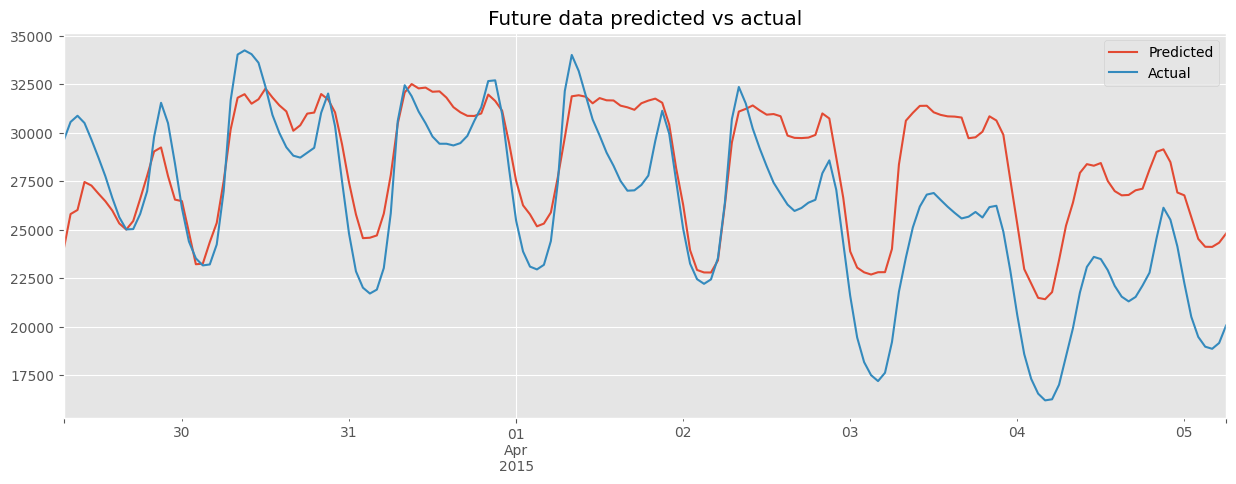

In [ ]:
FEATURES = ['hour',
            'weekend',
            'weekofyear',
            'month',
            'holiday',
            'lag_1_week',
            'lag_2_week',
            'lag_RollingMean',
            'lag_RollingMedian',
            'lag_temp_scaled']

# Prediction with all variables
print(FEATURES)
get_week_pred(FEATURES)

['hour', 'weekend', 'weekofyear', 'month', 'holiday']
[0]	validation_0-rmse:0.13467
[999]	validation_0-rmse:0.06444
RMSE on Test Data: 3865.778819785156
R² Score on Test Data: 0.20671982060883354


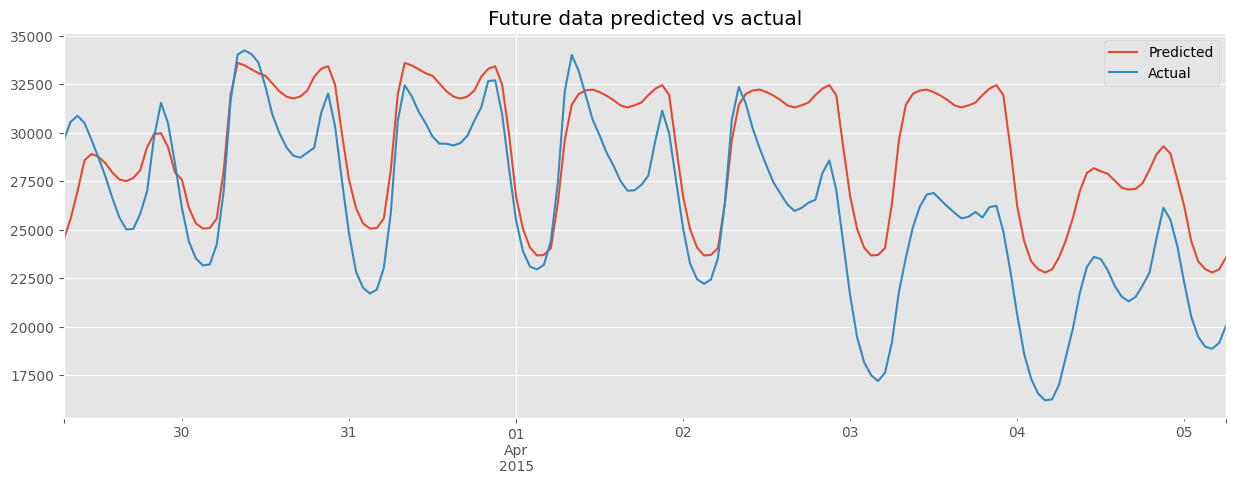

In [ ]:
# prediction with only pure date-time variables
print(FEATURES[:5])
get_week_pred(FEATURES[:5])

['lag_2_week', 'lag_RollingMean', 'lag_RollingMedian', 'lag_temp_scaled']
[0]	validation_0-rmse:0.13478
[999]	validation_0-rmse:0.07494
RMSE on Test Data: 7144.382262791097
R² Score on Test Data: -1.7094551465278363


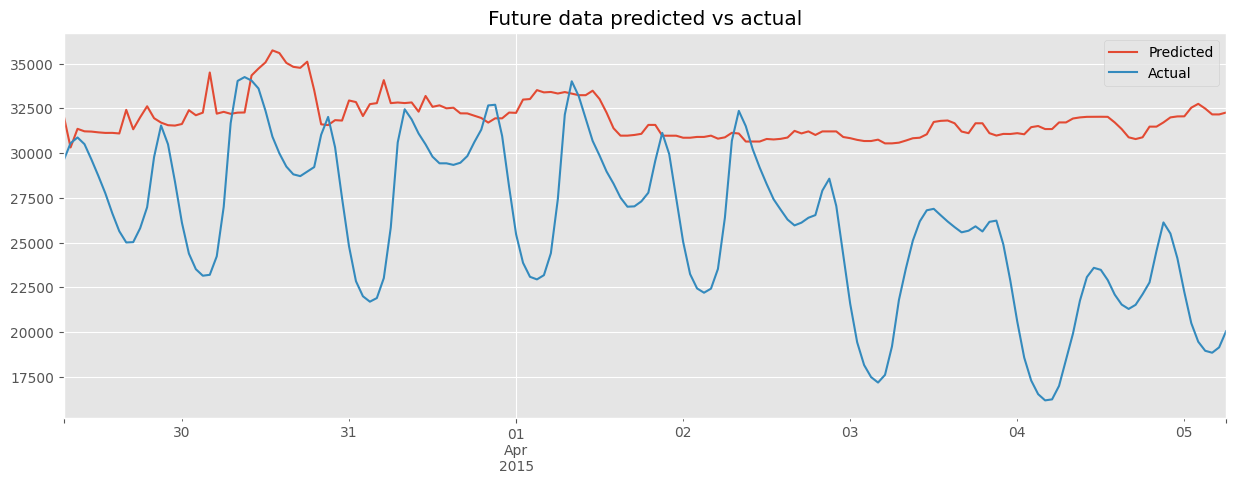

In [ ]:
# prediction with only pure lag variables
print(FEATURES[6:])
get_week_pred(FEATURES[6:])

In [ ]:
FEATURES

['hour',
 'weekend',
 'weekofyear',
 'month',
 'holiday',
 'lag_1_week',
 'lag_2_week',
 'lag_RollingMean',
 'lag_RollingMedian',
 'lag_temp_scaled']

In [ ]:
combo1 = [FEATURES[0], FEATURES[2], FEATURES[4], FEATURES[5], FEATURES[6]]

In [ ]:
print(combo1)

['hour', 'weekofyear', 'holiday', 'lag_1_week', 'lag_2_week']


[0]	validation_0-rmse:0.13467
[999]	validation_0-rmse:0.06301
RMSE on Test Data: 3340.9550607219244
R² Score on Test Data: 0.4074924800370968


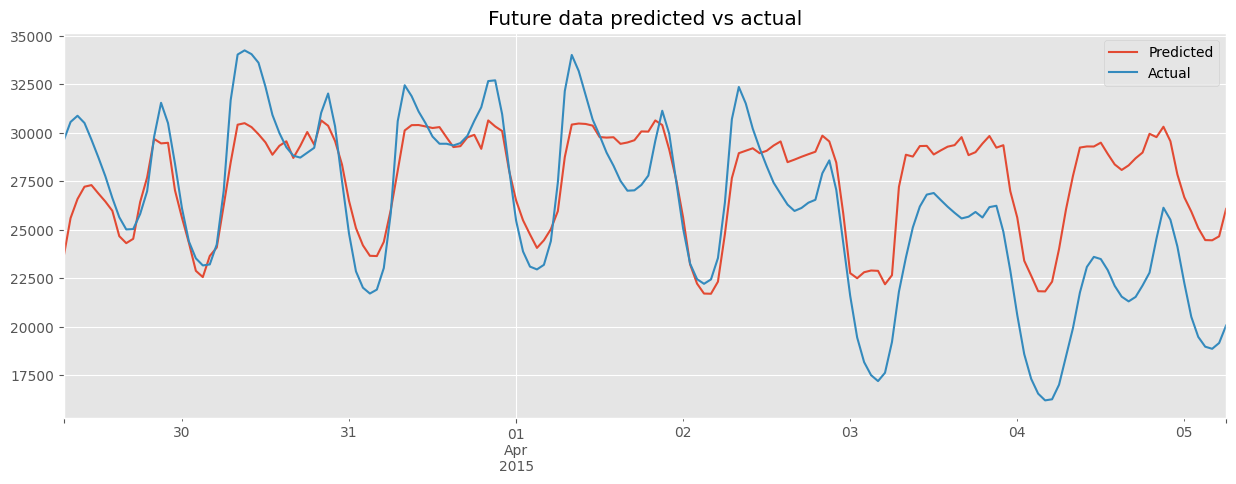

In [ ]:
# prediction with custom combination

get_week_pred(combo1)

In [ ]:
FEATURES

['hour',
 'weekend',
 'weekofyear',
 'month',
 'holiday',
 'lag_1_week',
 'lag_2_week',
 'lag_RollingMean',
 'lag_RollingMedian',
 'lag_temp_scaled']

In [ ]:
combo2 = [FEATURES[0], FEATURES[2], FEATURES[4], FEATURES[5], FEATURES[6], FEATURES[-2]]

In [ ]:
print(combo2)

['hour', 'weekofyear', 'holiday', 'lag_1_week', 'lag_2_week', 'lag_RollingMedian']


[0]	validation_0-rmse:0.13467
[999]	validation_0-rmse:0.05849
RMSE on Test Data: 3188.7322673888875
R² Score on Test Data: 0.4602548957730701


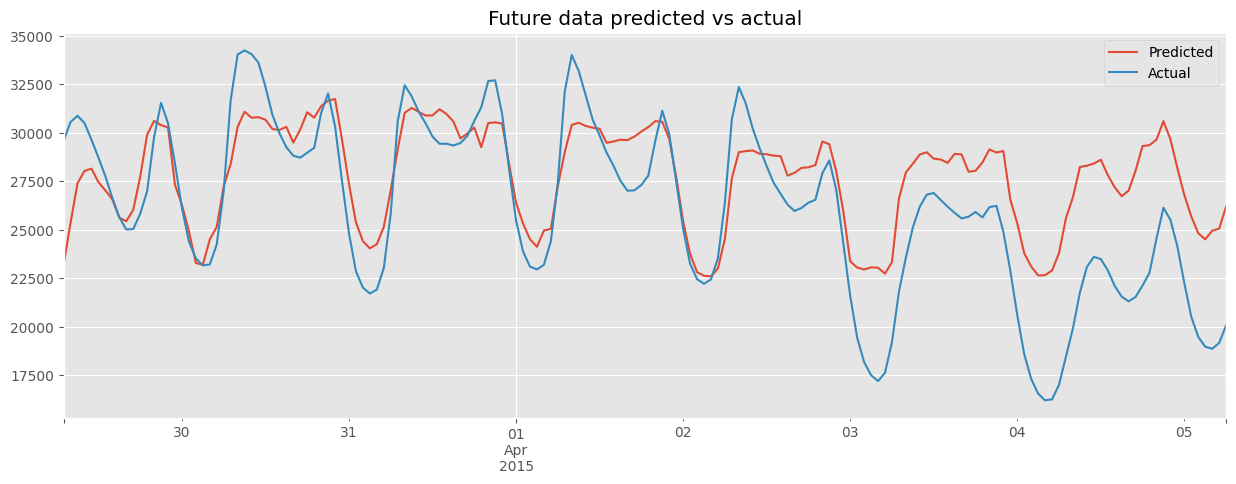

In [ ]:
# prediction with custom combination

get_week_pred(combo2)

# In summary

Grid Search and XGBoost Regressor can be used for figuring out metrics such as feature importance for variables in decision trees for forecasting. I think that there is a lot more potential here that I am sadly unable to tap into. I think also that the R^2 being lower despite the RMSE being lower as well from other models featured in this project highlights one of the core challenges with feature engineering, especially in a model like XGBoost. Adding features to data can reduce error, but it can also decrease a model's explainablity, and increases the complexity of the training process. All in all, working on this section was challenging, however that is what also makes it was a valuable experience for me. Trying to mesh feature engineering and grid search together to get a decent result opened my eyes to how much potential there is to both go wrong and go right while model tuning.